# Imports

In [1]:

import pandas as pd
import numpy as np
import zipfile
# For data visualization
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import plotly.offline as po
import plotly.graph_objs as go


In [2]:
# For models
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, auc,
    plot_confusion_matrix, plot_roc_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [3]:
# Pandas display options
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.max_info_columns', 500)
pd.set_option('display.max_info_rows', 2000)
pd.set_option('display.expand_frame_repr', True)
pd.set_option('display.width', 2000)
pd.set_option('display.max_rows', 500)

# Reading Data

Let's look at 10000 records first.

In [4]:
df_scan = pd.read_csv('data/Loan_status_2007-2020Q3.gzip', nrows=10000, low_memory=False)
df_scan.head()

Unnamed: 0       id  loan_amnt  funded_amnt  funded_amnt_inv        term int_rate  installment grade sub_grade                 emp_title emp_length home_ownership  annual_inc verification_status   issue_d  loan_status pymnt_plan                                                               url         purpose                 title zip_code addr_state    dti  delinq_2yrs earliest_cr_line  fico_range_low  fico_range_high  inq_last_6mths  mths_since_last_delinq  mths_since_last_record  open_acc  pub_rec  revol_bal revol_util  total_acc initial_list_status  out_prncp  out_prncp_inv   total_pymnt  total_pymnt_inv  total_rec_prncp  total_rec_int  total_rec_late_fee  recoveries  collection_recovery_fee last_pymnt_d  last_pymnt_amnt  next_pymnt_d last_credit_pull_d  last_fico_range_high  last_fico_range_low  collections_12_mths_ex_med  mths_since_last_major_derog  policy_code application_type  annual_inc_joint  dti_joint  verification_status_joint  acc_now_delinq  tot_coll_amt  tot_cur_bal  open_acc_6m  open_act_il  open_il_12m  open_il_24m  mths_since_rcnt_il  total_bal_il  il_util  open_rv_12m  open_rv_24m  max_bal_bc  all_util  total_rev_hi_lim  inq_fi  total_cu_tl  inq_last_12m  acc_open_past_24mths  avg_cur_bal  bc_open_to_buy  bc_util  chargeoff_within_12_mths  delinq_amnt  mo_sin_old_il_acct  mo_sin_old_rev_tl_op  mo_sin_rcnt_rev_tl_op  mo_sin_rcnt_tl  mort_acc  mths_since_recent_bc  mths_since_recent_bc_dlq  mths_since_recent_inq  mths_since_recent_revol_delinq  num_accts_ever_120_pd  num_actv_bc_tl  num_actv_rev_tl  num_bc_sats  num_bc_tl  num_il_tl  num_op_rev_tl  num_rev_accts  num_rev_tl_bal_gt_0  num_sats  num_tl_120dpd_2m  num_tl_30dpd  num_tl_90g_dpd_24m  num_tl_op_past_12m  pct_tl_nvr_dlq  percent_bc_gt_75  pub_rec_bankruptcies  tax_liens  tot_hi_cred_lim  total_bal_ex_mort  total_bc_limit  total_il_high_credit_limit  revol_bal_joint  sec_app_fico_range_low  sec_app_fico_range_high  sec_app_earliest_cr_line  sec_app_inq_last_6mths  sec_app_mort_acc  \
0           0  1077501       5000         5000           4975.0   36 months   10.65%       162.87     B        B2                       NaN  10+ years           RENT     24000.0            Verified  Dec-2011   Fully Paid          n  https://lendingclub.com/browse/loanDetail.action?loan_id=1077501     credit_card              Computer    860xx         AZ  27.65            0         Jan-1985             735              739               1                     NaN                     NaN         3        0      13648      83.7%          9                   f        0.0            0.0   5863.155187          5833.84          5000.00         863.16                0.00         0.0                     0.00     Jan-2015           171.62           NaN           May-2020                   704                  700                           0                          NaN            1       Individual               NaN        NaN                        NaN               0           NaN          NaN          NaN          NaN          NaN          NaN                 NaN           NaN      NaN          NaN          NaN         NaN       NaN               NaN     NaN          NaN           NaN                   NaN          NaN             NaN      NaN                         0            0                 NaN                   NaN                    NaN             NaN       NaN                   NaN                       NaN                    NaN                             NaN                    NaN             NaN              NaN          NaN        NaN        NaN            NaN            NaN                  NaN       NaN               NaN           NaN                 NaN                 NaN             NaN               NaN                     0          0              NaN                NaN             NaN                         NaN              NaN                     NaN                      NaN                       NaN                     NaN               NaN   
1        

In [5]:
df_scan.shape

(10000, 142)

There are 142 columns, check the information of them.

In [6]:
df_scan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 142 columns):
 #    Column                                      Dtype  
---   ------                                      -----  
 0    Unnamed: 0                                  int64  
 1    id                                          int64  
 2    loan_amnt                                   int64  
 3    funded_amnt                                 int64  
 4    funded_amnt_inv                             float64
 5    term                                        object 
 6    int_rate                                    object 
 7    installment                                 float64
 8    grade                                       object 
 9    sub_grade                                   object 
 10   emp_title                                   object 
 11   emp_length                                  object 
 12   home_ownership                              object 
 13   annual_inc     

Our target value is loan_status.

In [7]:
df_scan.loan_status.value_counts()

Fully Paid     8429
Charged Off    1571
Name: loan_status, dtype: int64

Creating a new column to label Charged Off as 1 and Fully Paid as 0. 

In [8]:
df_scan['charged_off'] = df_scan.loan_status.map({'Fully Paid':0, 'Charged Off':1})

In [9]:
df_scan.corr()['charged_off'].sort_values(ascending=False)

charged_off                                   1.000000
recoveries                                    0.368135
collection_recovery_fee                       0.266003
total_rec_late_fee                            0.134564
inq_last_6mths                                0.067429
loan_amnt                                     0.060530
funded_amnt_inv                               0.059716
funded_amnt                                   0.059157
pub_rec                                       0.049188
dti                                           0.047124
pub_rec_bankruptcies                          0.043977
id                                            0.040318
installment                                   0.034380
mths_since_last_record                        0.026285
delinq_2yrs                                   0.025272
total_rec_int                                 0.010236
mths_since_last_delinq                        0.006358
open_acc                                     -0.006175
revol_bal 

According to the correlation check with 'charged_off' and some research. We will select features which affect 'charged off' and would be available to a investor before deciding to fund the loan.

In [10]:
selected_feature = ['loan_amnt','term','int_rate','installment','grade','sub_grade','emp_title','emp_length','home_ownership',
                   'annual_inc','verification_status','purpose','title','dti','earliest_cr_line','open_acc','pub_rec','revol_bal','revol_util','total_acc','initial_list_status','application_type','mort_acc',
                    'pub_rec_bankruptcies','addr_state','fico_range_low','fico_range_high','loan_status','issue_d']


In [11]:
len(selected_feature)

29

Reading Whole Dataset with Selected Features

In [12]:
loan = pd.read_csv('data/Loan_status_2007-2020Q3.gzip', usecols=selected_feature)
loan.head()

loan_amnt        term int_rate  installment grade sub_grade                 emp_title emp_length home_ownership  annual_inc verification_status   issue_d  loan_status         purpose                 title addr_state    dti earliest_cr_line  fico_range_low  fico_range_high  open_acc  pub_rec  revol_bal revol_util  total_acc initial_list_status application_type  mort_acc  pub_rec_bankruptcies
0     5000.0   36 months   10.65%       162.87     B        B2                       NaN  10+ years           RENT     24000.0            Verified  Dec-2011   Fully Paid     credit_card              Computer         AZ  27.65         Jan-1985           735.0            739.0       3.0      0.0    13648.0      83.7%        9.0                   f       Individual       NaN                   0.0
1     2500.0   60 months   15.27%        59.83     C        C4                     Ryder   < 1 year           RENT     30000.0     Source Verified  Dec-2011  Charged Off             car                  bike         GA   1.00         Apr-1999           740.0            744.0       3.0      0.0     1687.0       9.4%        4.0                   f       Individual       NaN                   0.0
2     2400.0   36 months   15.96%        84.33     C        C5                       NaN  10+ years           RENT     12252.0        Not Verified  Dec-2011   Fully Paid  small_business  real estate business         IL   8.72         Nov-2001           735.0            739.0       2.0      0.0     2956.0      98.5%       10.0                   f       Individual       NaN                   0.0
3    10000.0   36 months   13.49%       339.31     C        C1       AIR RESOURCES BOARD  10+ years           RENT     49200.0     Source Verified  Dec-2011   Fully Paid           other              personel         CA  20.00         Feb-1996           690.0            694.0      10.0      0.0     5598.0        21%       37.0                   f       Individual       NaN                   0.0
4     3000.0   60 months   12.69%        67.79     B        B5  University Medical Group     1 year           RENT     80000.0     Source Verified  Dec-2011   Fully Paid           other              Personal         OR  17.94         Jan-1996           695.0            699.0      15.0      0.0    27783.0      53.9%       38.0                   f       Individual       NaN                   0.0

In [13]:
loan.shape

(2925493, 29)

We totally have more than 2.9 million records and 29 features.

In [14]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2925493 entries, 0 to 2925492
Data columns (total 29 columns):
 #   Column                Dtype  
---  ------                -----  
 0   loan_amnt             float64
 1   term                  object 
 2   int_rate              object 
 3   installment           float64
 4   grade                 object 
 5   sub_grade             object 
 6   emp_title             object 
 7   emp_length            object 
 8   home_ownership        object 
 9   annual_inc            float64
 10  verification_status   object 
 11  issue_d               object 
 12  loan_status           object 
 13  purpose               object 
 14  title                 object 
 15  addr_state            object 
 16  dti                   float64
 17  earliest_cr_line      object 
 18  fico_range_low        float64
 19  fico_range_high       float64
 20  open_acc              float64
 21  pub_rec               float64
 22  revol_bal             float64
 23  revol_u

In [15]:
loan.describe()

loan_amnt   installment    annual_inc           dti  fico_range_low  fico_range_high      open_acc       pub_rec     revol_bal     total_acc      mort_acc  pub_rec_bankruptcies
count  2.925492e+06  2.925492e+06  2.925488e+06  2.922384e+06    2.925492e+06     2.925492e+06  2.925463e+06  2.925463e+06  2.925492e+06  2.925463e+06  2.875462e+06          2.924127e+06
mean   1.535878e+04  4.523914e+02  7.993727e+04  1.929648e+01    7.005110e+02     7.045112e+02  1.167616e+01  1.762846e-01  1.696484e+04  2.401835e+01  1.512336e+00          1.226790e-01
std    9.478383e+03  2.729478e+02  1.117476e+05  1.571977e+01    3.376565e+01     3.376653e+01  5.733312e+00  5.243762e-01  2.299621e+04  1.207625e+01  1.869776e+00          3.531414e-01
min    5.000000e+02  4.930000e+00  0.000000e+00 -1.000000e+00    6.100000e+02     6.140000e+02  0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00  0.000000e+00          0.000000e+00
25%    8.000000e+03  2.535000e+02  4.700000e+04  1.208000e+01    6.750000e+02     6.790000e+02  8.000000e+00  0.000000e+00  5.993000e+03  1.500000e+01  0.000000e+00          0.000000e+00
50%    1.300000e+04  3.823000e+02  6.600000e+04  1.810000e+01    6.950000e+02     6.990000e+02  1.100000e+01  0.000000e+00  1.149300e+04  2.200000e+01  1.000000e+00          0.000000e+00
75%    2.000000e+04  6.039200e+02  9.500000e+04  2.488000e+01    7.200000e+02     7.240000e+02  1.500000e+01  0.000000e+00  2.064400e+04  3.100000e+01  2.000000e+00          0.000000e+00
max    4.000000e+04  1.719830e+03  1.100000e+08  9.990000e+02    8.450000e+02     8.500000e+02  1.040000e+02  8.600000e+01  2.904836e+06  1.760000e+02  9.400000e+01          1.200000e+01

**Check and Remove Duplicates**



In [16]:
print('Shape before drop duplicates:', loan.shape)
loan.drop_duplicates(inplace=True)
print('Shape after drop duplicates:', loan.shape)

Shape before drop duplicates: (2925493, 29)
Shape after drop duplicates: (2925493, 29)


# **Exploratory Data Analysis**

## Pre Works

Create a new column named 'lona_status_flag' and label 'Charged Off' as 1 and 'Fully Paid' as 0.

In [17]:
loan['loan_status_flag'] = loan['loan_status'].map({'Fully Paid':0,'Charged Off':1})

Define a function to caluculate the percent of charged off.

In [18]:
def cfratio(data,feature):
    '''
    This function is to calculate the ratio of charged off
    Input:
    data: a dataframe
    feature: a column in data
    Output:
    percent: charged_off/(charged_off + fully_paid)
    '''
    percent = data.groupby(feature)['loan_status_flag'].mean()
    #percent.rename(columns={'loan_status_flag':'Charged_Off_Percent'},inplace=True)
    return percent

For some continuous variables, we need to group these variables if we want to see the charged off percent for each group.

In [19]:
def group(var, bins):
    '''
    This function is to group continuous variables by quantiles.
    Input:
    var: the continuous variable need be group
    bins: the number of group
    Output:
    An array-like object representing the respective bin for each value of var
    '''
    group = pd.qcut(loan[var],bins)
    return group

In [20]:
# color & palette
pal = ['#130c23','#2c1641','#49205a','#68296b','#863576','#a2437c','#b9537e','#cc6680','#e17c83','#e5ac93','#e8c4a4','#ecdbbd','#f2eedb']
gwu = ['#AA9868','#033C5A']

In [21]:
#Create a new empty list to store the variables that we no longer need.
dropl = []

Grab the year which the loan was funded from 'issue_d' in order to analyze the data by time.

In [22]:
loan['issue_y'] = pd.DatetimeIndex(loan['issue_d']).year.astype('Int64')
dropl.append('issue_d')

## **Target Value**

**loan_status**

loan_status: Current status of the loan.

In [23]:
loan['loan_status'].value_counts()

Fully Paid                                             1497783
Current                                                1031016
Charged Off                                             362548
Late (31-120 days)                                       16154
In Grace Period                                          10028
Late (16-30 days)                                         2719
Issued                                                    2062
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                    433
Name: loan_status, dtype: int64

Text(0.5, 1.0, 'Number of Loan by Year')

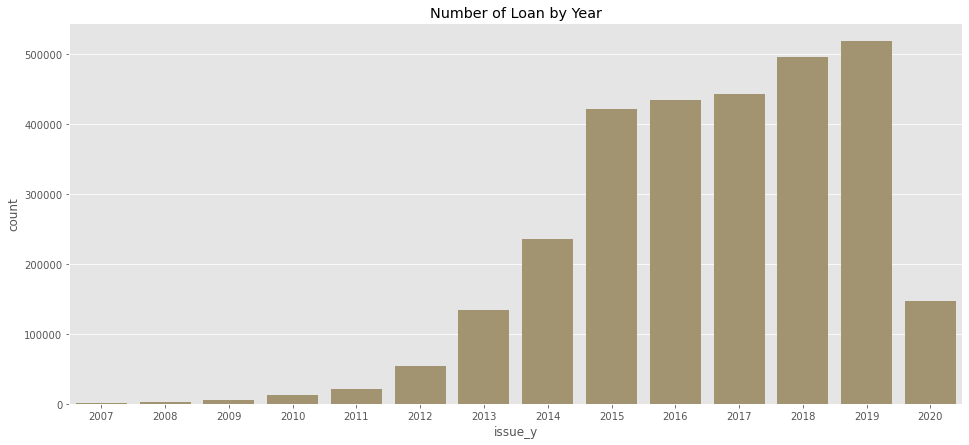

In [24]:
plt.figure(figsize=(16,7))
sns.countplot(data=loan, x=loan['issue_y'].sort_values(), color='#AA9868')
plt.title('Number of Loan by Year')

Due to the data only up to the third quarter of 2020, generally speaking the number of loans is rising year by year. 

In [25]:
loan.shape

(2925493, 31)

For prediction, we only need Fully Paid and Charged Off rows.

In [26]:
loan = loan[(loan['loan_status']=='Fully Paid') | (loan['loan_status']=='Charged Off')]

In [27]:
print('Number of rows after selection:',loan.shape[0])

Number of rows after selection: 1860331


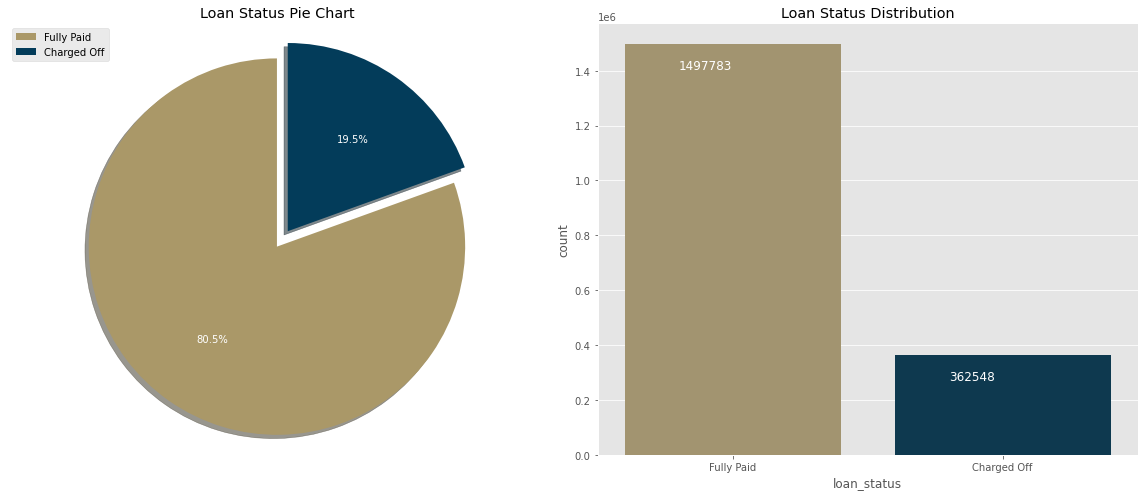

In [28]:
plt.figure(figsize=(16,7))
plt.subplot(1,2,1)
plt.pie(
    loan['loan_status'].value_counts(), labels=['Fully Paid', 'Charged Off'],
    autopct='%1.1f%%', startangle=90, explode=(0,0.1), shadow=True,
    colors=['#AA9868','#033C5A'], textprops={'color':"w"}
    )
plt.legend(['Fully Paid', 'Charged Off'])
# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')
plt.title('Loan Status Pie Chart')
plt.subplot(1,2,2)
ax = sns.countplot(x='loan_status',data=loan, palette=['#AA9868','#033C5A'])
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}',(p.get_x()+0.2, p.get_height()), ha='left',va='top',color='w',size=12)
plt.title('Loan Status Distribution')
plt.tight_layout()



Approximately 1,500,000 loans have been fully paid, accounting for 80.5% of the completed loans. The number of default loans is about 360,000, accounting for 19.5%. The data is unbalanced.

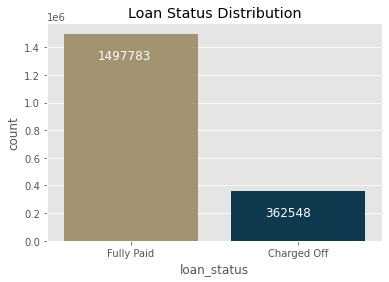

In [29]:
ax = sns.countplot(x='loan_status',data=loan, palette=['#AA9868','#033C5A'])
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}',(p.get_x()+0.2, p.get_height()), ha='left',va='top',color='w',size=12)
plt.title('Loan Status Distribution')
plt.show()

Loan counts and charged off ratio by year.

In [ ]:
ax1_df = loan.groupby('issue_y')['loan_status_flag'].count().reset_index()
ax2_df = cfratio(loan,'issue_y').reset_index()
#plot
fig,ax = plt.subplots(figsize=[16,7])
ax.bar(ax1_df['issue_y'],ax1_df['loan_status_flag'], color='#AA9868')
ax.set_xlabel('Year')
ax.set_ylabel('Loan Counts')
ax.set(facecolor = "white")
ax2 = ax.twinx()
ax2.plot(ax2_df['issue_y'], ax2_df['loan_status_flag'], label='Charged Off Ratio',color='#033C5A', marker='o')
ax2.set_ylabel('Charged Off Ratio')
ax2.legend()
plt.show()

In all the loans that have been completed, number of loans reached its peak in 2015-2016, followed by a decrease from 2017. That's maybe because some loans are not completed yet. The charged off ratio reached its highest in 2018, and droped sharply.

Text(0.5, 1.0, 'Loan Status by Year')

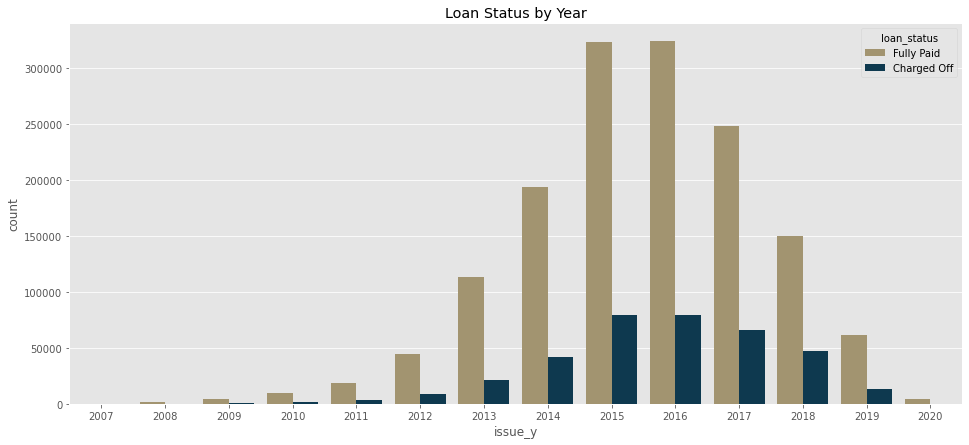

In [31]:
plt.figure(figsize=(16,7))
sns.countplot(data=loan, x='issue_y', hue='loan_status', palette=gwu)
plt.title('Loan Status by Year')

## **Other Values**


In this section, we will explore and analysis each feature. If there is an unnecessary or repetitive feature, we will drop it.

Let's see the correlation between loan status and numeric features.

Text(0.5, 1.0, 'Correlation between Loan Status and Numeric Features')

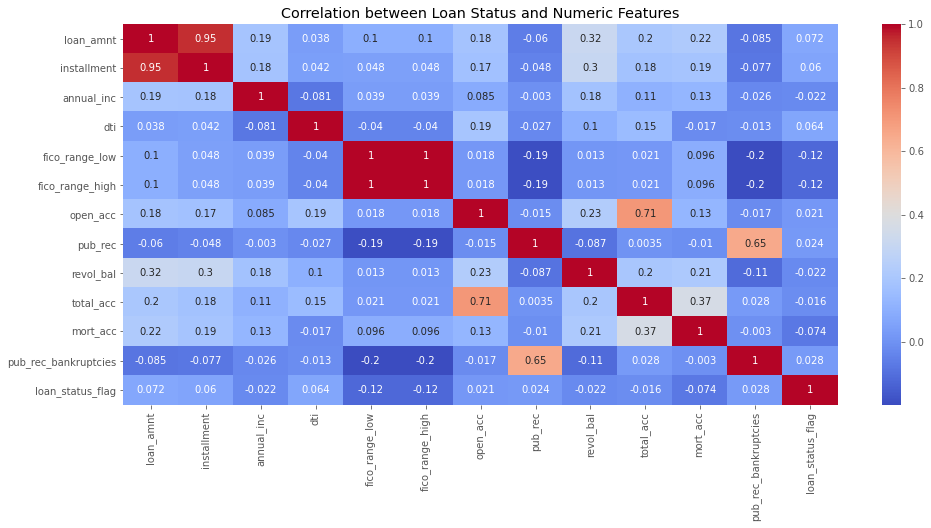

In [32]:
plt.figure(figsize=(16,7))
sns.heatmap(loan.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation between Loan Status and Numeric Features')

There are three pairs of variables highly correlated: loan_amnt and installment, open_acc and total_acc, pub_rec and pub_rec_bankruptcies. We need to drop one of each pair.
fico_range_high and fico_range_low are fully correlated, we will create a new feature for them.



**loan_amount vs installment**

loan_amnt: The listed amount of the loan applied for by the borrower. 

installment: The monthly payment owed by the borrower if the loan originates.

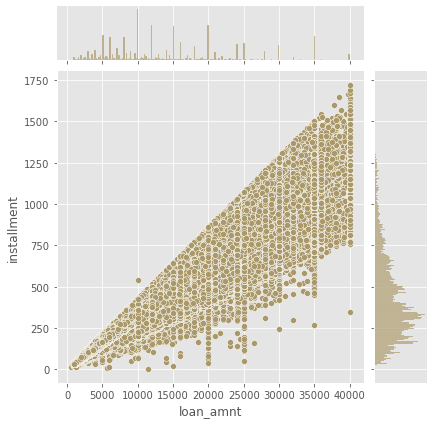

In [33]:
sns.jointplot(x='loan_amnt', y='installment', data=loan, color='#AA9868')

Text(0.5, 1.0, 'Installment Distribution by Loan Status')

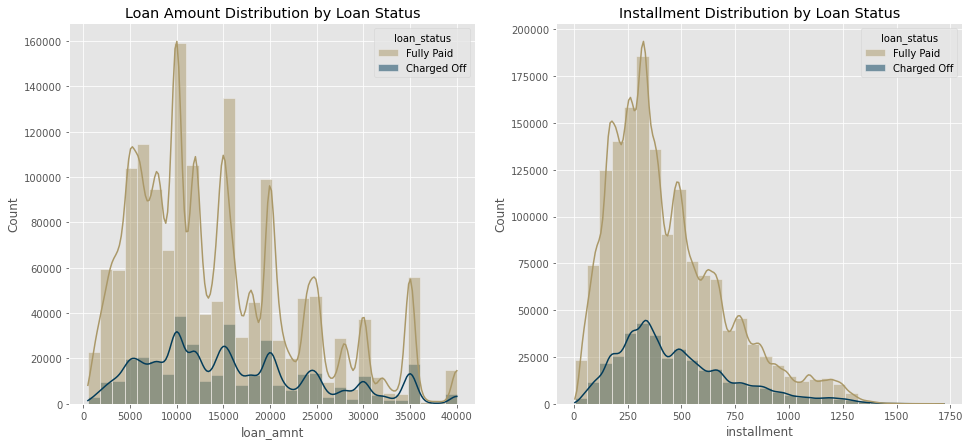

In [34]:
plt.figure(figsize=(16,7))
plt.subplot(1,2,1)
sns.histplot(data=loan, x='loan_amnt', hue='loan_status',bins=30, kde=True, palette=gwu)
plt.title('Loan Amount Distribution by Loan Status')
plt.subplot(1,2,2)
sns.histplot(data=loan, x='installment', hue='loan_status',bins=30, kde=True, palette=gwu)
plt.title('Installment Distribution by Loan Status')

'loan_amnt' and 'installment' are highly correlated, the correlation coefficient is 0.95. It's realistic that as loan amount increase, the installment will increase. And as 'loan_amnt' has a higher correlation coefficient with 'loan_status_flag'. So, we will drop 'installment'.

In [35]:
dropl.append('installment')

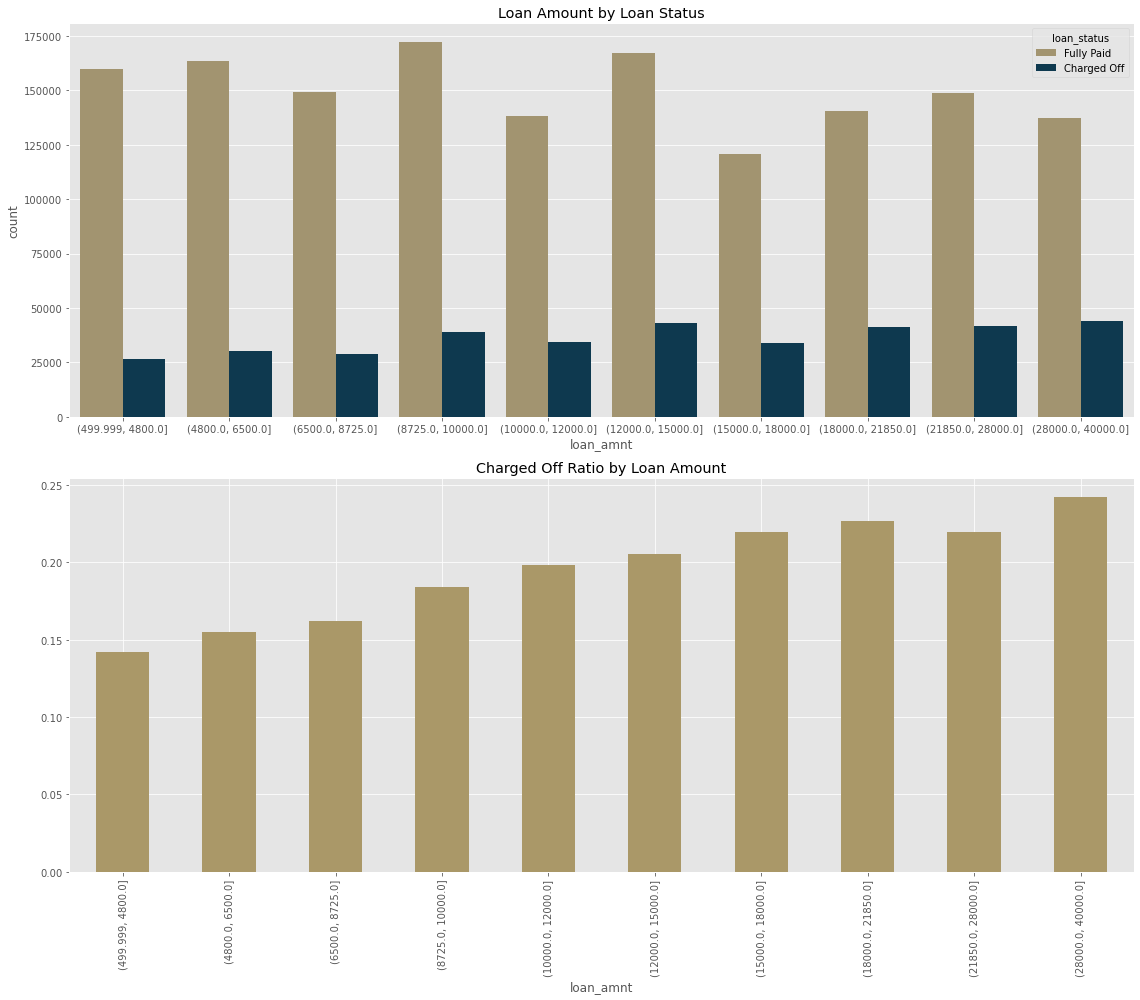

In [36]:
plt.figure(figsize=(16,14))
plt.subplot(2,1,1)
sns.countplot(data=loan, x=group('loan_amnt',10), hue='loan_status', palette=gwu)
plt.title('Loan Amount by Loan Status')
plt.subplot(2,1,2)
cfratio(loan,group('loan_amnt',10)).plot(kind='bar', color='#AA9868')
plt.title('Charged Off Ratio by Loan Amount')
plt.tight_layout()

As the loan amount grows, the charged off ratio rises.

**open_acc vs total_acc**

open_acc: The number of open credit lines in the borrower's credit file.

total_acc: The total number of credit lines currently in the borrower's credit file.


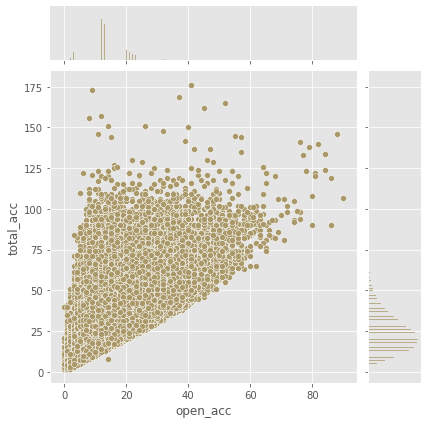

In [37]:
sns.jointplot(x='open_acc', y='total_acc', data=loan, color='#AA9868')

Text(0.5, 1.0, 'Total Accounts Distribution by Loan Status')

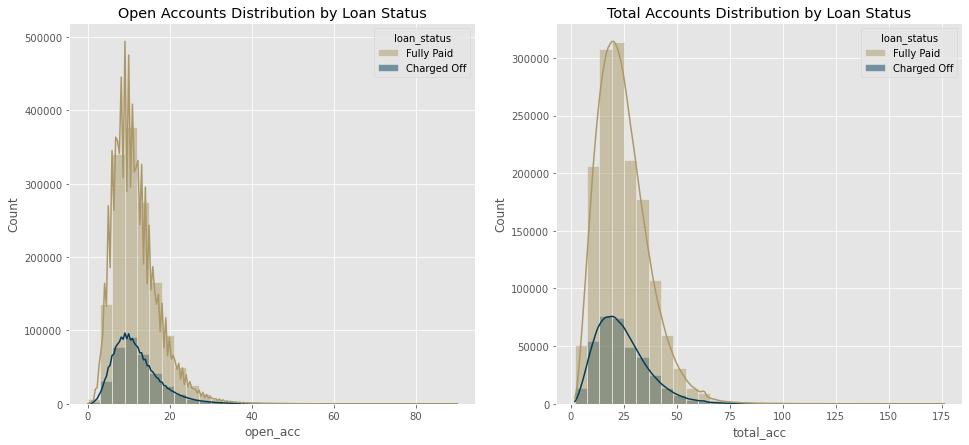

In [38]:
plt.figure(figsize=(16,7))
plt.subplot(1,2,1)
sns.histplot(data=loan, x='open_acc', hue='loan_status',bins=30, kde=True, palette=gwu)
plt.title('Open Accounts Distribution by Loan Status')
plt.subplot(1,2,2)
sns.histplot(data=loan, x='total_acc', hue='loan_status',bins=30, kde=True, palette=gwu)
plt.title('Total Accounts Distribution by Loan Status')

It seems there are no significant difference between open_acc and total_acc, so we will drop one.

In [39]:
dropl.append('total_acc')

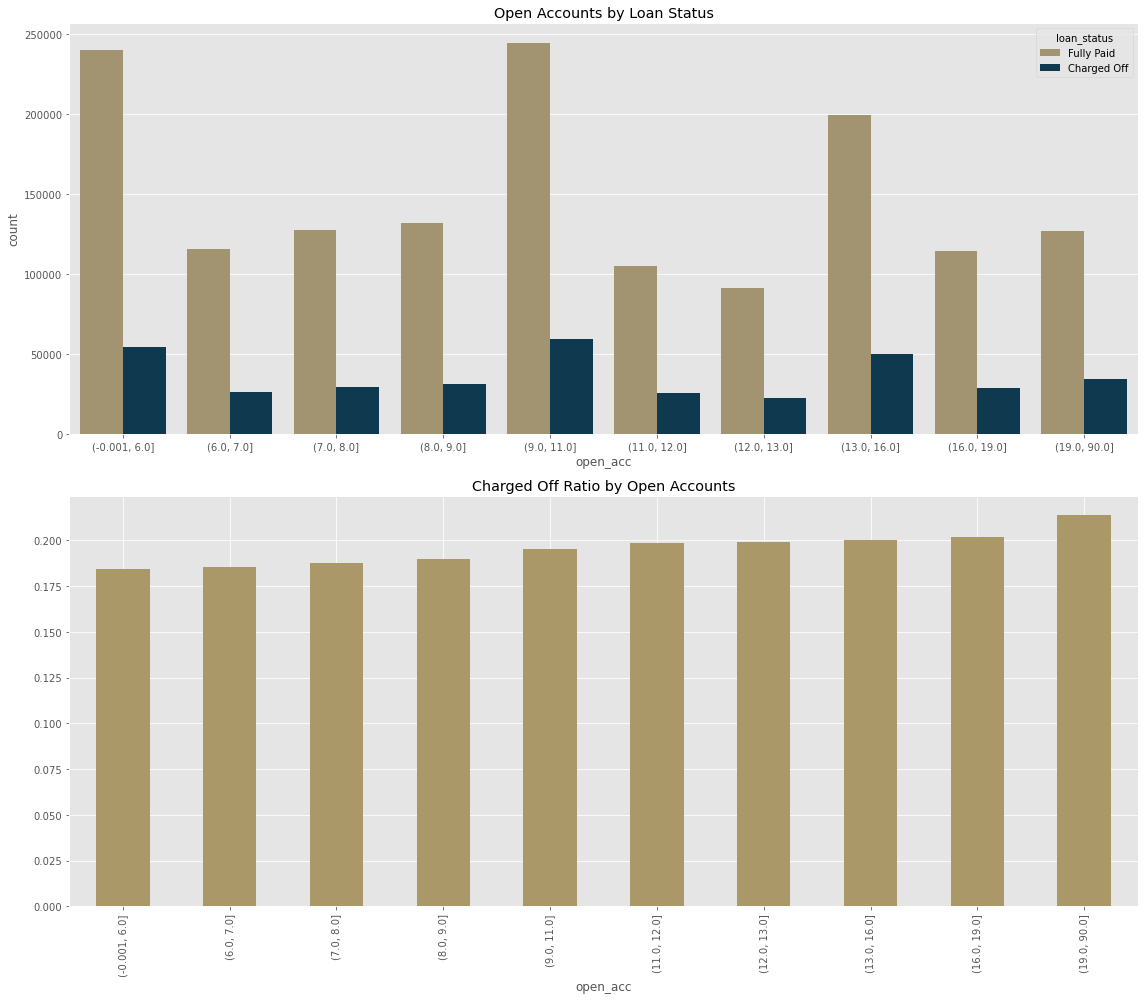

In [40]:
plt.figure(figsize=(16,14))
plt.subplot(2,1,1)
sns.countplot(data=loan, x=group('open_acc',10), hue='loan_status', palette=gwu)
plt.title('Open Accounts by Loan Status')
plt.subplot(2,1,2)
cfratio(loan,group('open_acc',10)).plot(kind='bar', color='#AA9868')
plt.title('Charged Off Ratio by Open Accounts')
plt.tight_layout()

‘open_acc’ has little effect on the charged off ratio, but it can be seen that as the number of open accounts increases, the default rate rises slightly.

**pub_rec vs pub_rec_bankruptcies**

pub_rec: Number of derogatory public records.

pub_rec_bankruptcies: Number of public record bankruptcies.

In [41]:
loan['pub_rec_bankruptcies'].value_counts()

0.0     1628840
1.0      218344
2.0        9723
3.0        1952
4.0         505
5.0         177
6.0          58
7.0          21
8.0           9
9.0           3
12.0          1
11.0          1
Name: pub_rec_bankruptcies, dtype: int64

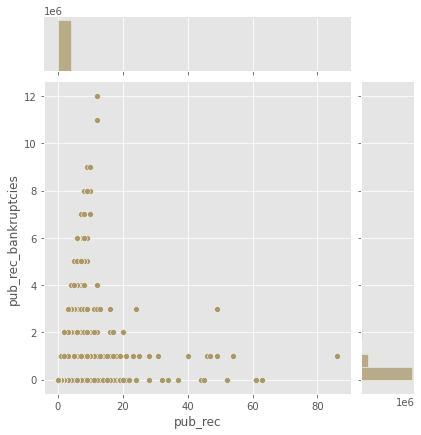

In [42]:
sns.jointplot(x='pub_rec', y='pub_rec_bankruptcies', data=loan, color='#AA9868')

Text(0.5, 1.0, 'Public Bankrupticies Record Distribution by Loan Status')

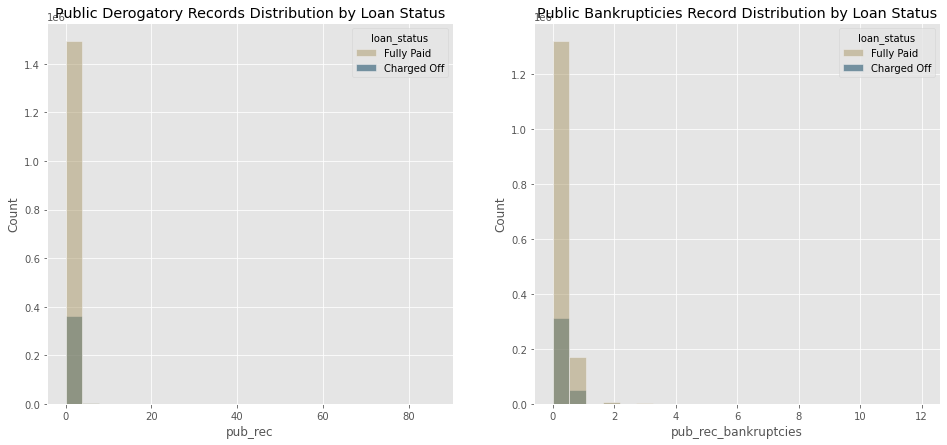

In [43]:
plt.figure(figsize=(16,7))
plt.subplot(1,2,1)
sns.histplot(data=loan, x='pub_rec', hue='loan_status', palette=gwu)
plt.title('Public Derogatory Records Distribution by Loan Status')
plt.subplot(1,2,2)
sns.histplot(data=loan, x='pub_rec_bankruptcies', hue='loan_status', palette=gwu)
plt.title('Public Bankrupticies Record Distribution by Loan Status')

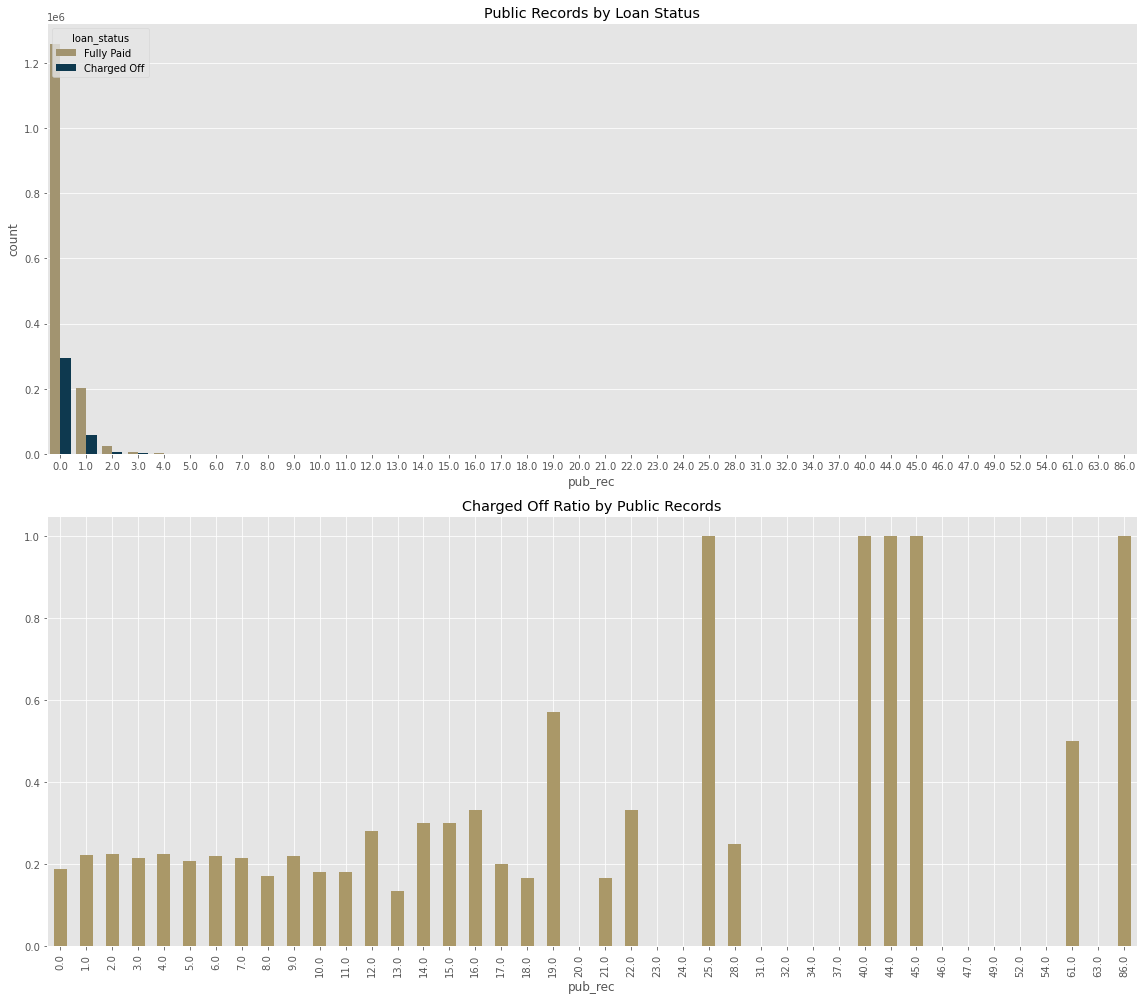

In [44]:
plt.figure(figsize=(16,14))
plt.subplot(2,1,1)
sns.countplot(data=loan, x='pub_rec', hue='loan_status', palette=gwu)
plt.title('Public Records by Loan Status')
plt.subplot(2,1,2)
cfratio(loan,'pub_rec').plot(kind='bar', color='#AA9868')
plt.title('Charged Off Ratio by Public Records')
plt.tight_layout()

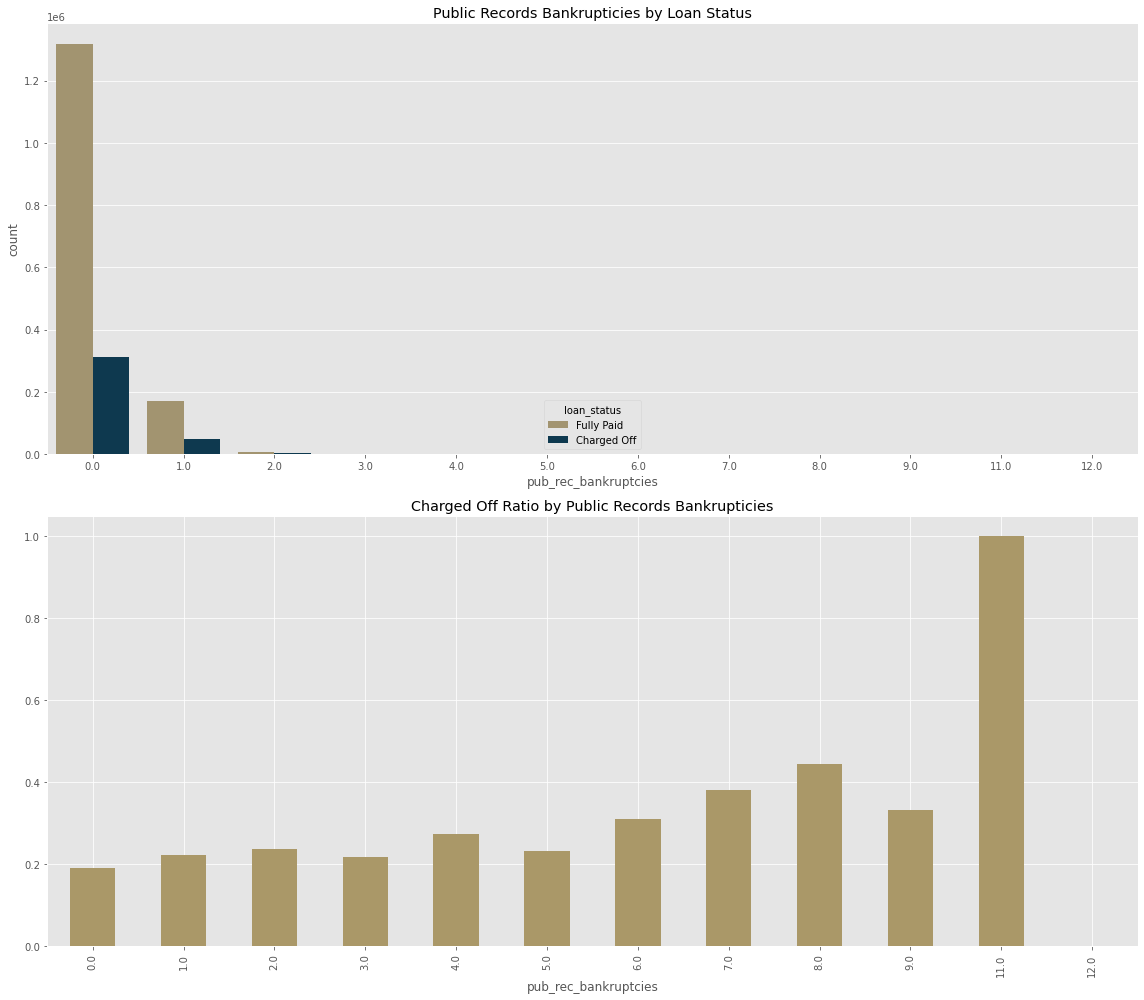

In [45]:
plt.figure(figsize=(16,14))
plt.subplot(2,1,1)
sns.countplot(data=loan, x='pub_rec_bankruptcies', hue='loan_status', palette=gwu)
plt.title('Public Records Bankrupticies by Loan Status')
plt.subplot(2,1,2)
cfratio(loan,'pub_rec_bankruptcies').plot(kind='bar', color='#AA9868')
plt.title('Charged Off Ratio by Public Records Bankrupticies')
plt.tight_layout()

People who have more derogatory public records and public record bankruptcies  will have higher charged off percent.

**fico_range_low vs fico_range_high**

fico_range_low: The lower boundary range the borrower’s FICO at loan origination belongs to.

fico_range_high: The upper boundary range the borrower’s FICO at loan origination belongs to.

In [46]:
loan[['fico_range_low','fico_range_high']].describe()

fico_range_low  fico_range_high
count    1.860331e+06     1.860331e+06
mean     6.976785e+02     7.016786e+02
std      3.270865e+01     3.270940e+01
min      6.250000e+02     6.290000e+02
25%      6.700000e+02     6.740000e+02
50%      6.900000e+02     6.940000e+02
75%      7.150000e+02     7.190000e+02
max      8.450000e+02     8.500000e+02

In [47]:
loan.groupby('loan_status')[['fico_range_low','fico_range_high']].describe().reset_index()

loan_status fico_range_low                                                           fico_range_high                                                          
                        count        mean        std    min    25%    50%    75%    max           count        mean        std    min    25%    50%    75%    max
0  Charged Off       362548.0  689.666306  27.320065  660.0  670.0  685.0  705.0  845.0        362548.0  693.666397  27.320584  664.0  674.0  689.0  709.0  850.0
1   Fully Paid      1497783.0  699.617875  33.598429  625.0  675.0  690.0  715.0  845.0       1497783.0  703.618057  33.599221  629.0  679.0  694.0  719.0  850.0

Text(0.5, 1.0, 'High Boundary range of FICO Distribution by Loan Status')

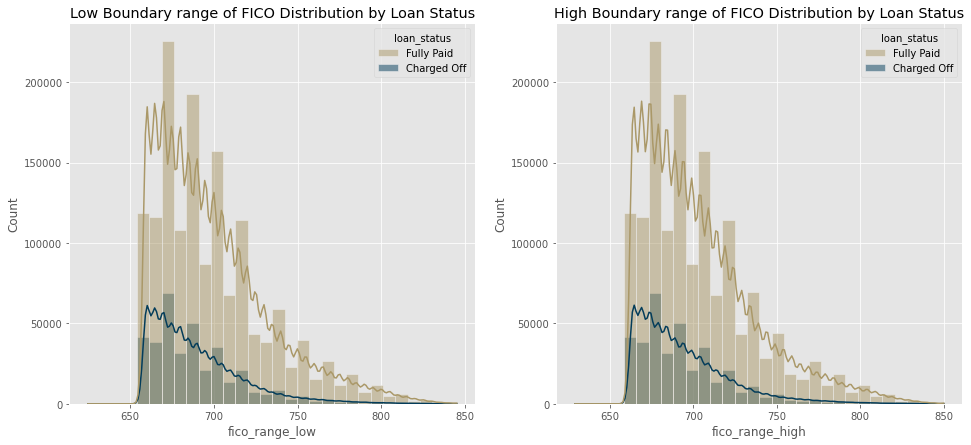

In [48]:
plt.figure(figsize=(16,7))
plt.subplot(1,2,1)
sns.histplot(data=loan, x='fico_range_low', hue='loan_status',bins=30, kde=True, palette=gwu)
plt.title('Low Boundary range of FICO Distribution by Loan Status')
plt.subplot(1,2,2)
sns.histplot(data=loan, x='fico_range_high', hue='loan_status',bins=30, kde=True, palette=gwu)
plt.title('High Boundary range of FICO Distribution by Loan Status')

In [49]:
loan['fico'] = (loan['fico_range_high'] + loan['fico_range_low'])/2
dropl.extend(['fico_range_high','fico_range_low'])

In [50]:
loan['fico'].describe()

count    1.860331e+06
mean     6.996786e+02
std      3.270902e+01
min      6.270000e+02
25%      6.720000e+02
50%      6.920000e+02
75%      7.170000e+02
max      8.475000e+02
Name: fico, dtype: float64

Text(0.5, 1.0, 'FICO Score Distribution by Loan Status')

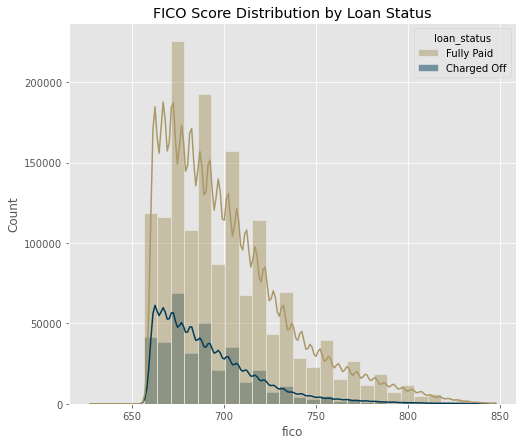

In [51]:
plt.figure(figsize=(8,7))
sns.histplot(data=loan, x='fico', hue='loan_status', bins=30, kde=True, palette=gwu)
plt.title('FICO Score Distribution by Loan Status')

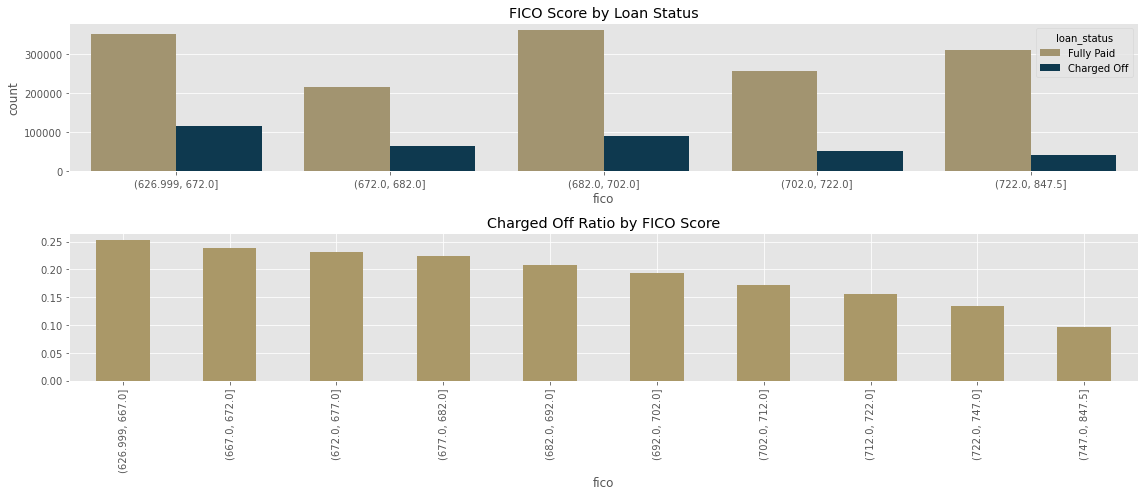

In [52]:
plt.figure(figsize=(16,7))
plt.subplot(2,1,1)
sns.countplot(data=loan, x=group('fico',5), hue='loan_status', palette=gwu)
plt.title('FICO Score by Loan Status')
plt.subplot(2,1,2)
cfratio(loan,group('fico',10)).plot(kind='bar', color='#AA9868')
plt.title('Charged Off Ratio by FICO Score')
plt.tight_layout()

It's obviously that as the FICO score increase, the charged off percent decrease. Charged off loans have a FICO score 10 points lower on average.

There also have some similar features, like 'grade' and 'sub_grade', 'emp_title' and 'emp_length', 'purpose' and 'title'.

**grade and sub_grade**

grade: LC assigned loan grade.

sub_grade: LC assigned loan subgrade.

In [53]:
print("'grade' unique values: ", sorted(loan['grade'].unique()))
print("'sub_grade' unique values: ", sorted(loan['sub_grade'].unique()))

'grade' unique values:  ['A', 'B', 'C', 'D', 'E', 'F', 'G']
'sub_grade' unique values:  ['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5']


The grade is implied by the subgrade. So, we will drop grade.

In [54]:
dropl.append('grade')

<AxesSubplot:xlabel='sub_grade', ylabel='count'>

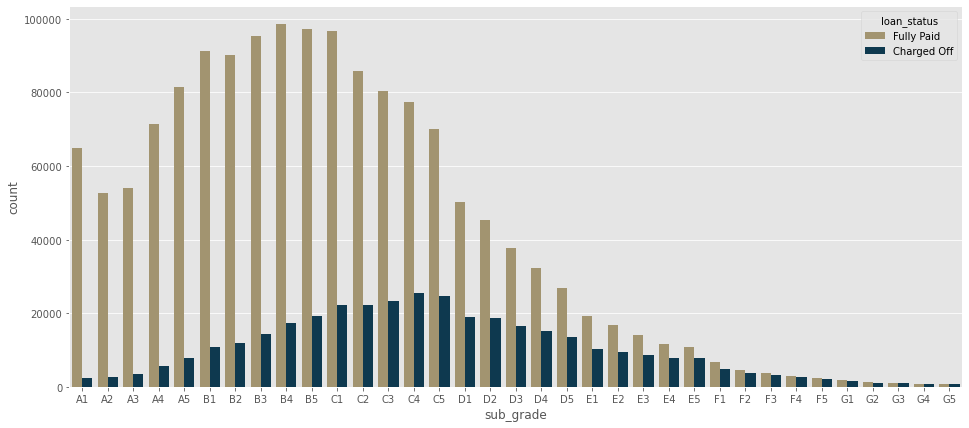

In [55]:
plt.figure(figsize=(16,7))
sub_grade = sorted(loan['sub_grade'].unique().tolist())
sns.countplot(x='sub_grade', data=loan, hue='loan_status', order=sub_grade, palette=gwu)

Text(0.5, 1.0, 'Charged Off Ratio by Sub Grade')

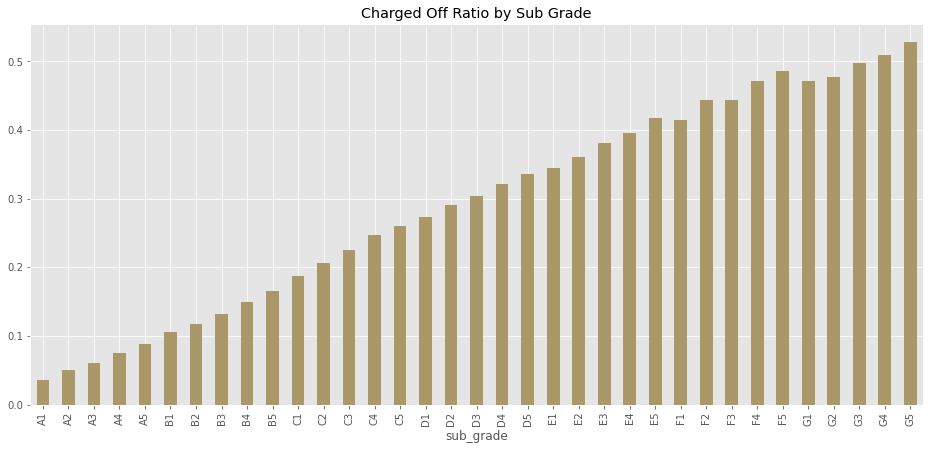

In [56]:
plt.figure(figsize=(16,7))
cfratio(loan,'sub_grade').plot(kind='bar',color='#AA9868')
plt.title('Charged Off Ratio by Sub Grade')

As the sub grade getting worse, the number of charged off is catch up with even exceed the number of fully paid, meanwhile the charged off percent is getthing larger.

**emp_title and emp_length**

emp_title: The job title supplied by the Borrower when applying for the loan.

emp_length: Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.

In [57]:
print('There are {} unique job titles.'.format(loan['emp_title'].nunique()))

There are 456676 unique job titles.


There are too many unique values in 'emp_title' value, it will be difficult to convert this to a dummy variable feature. So, we will drop this variable.

In [58]:
dropl.append('emp_title')

Text(0.5, 1.0, 'The most 20 jobs title afforded a loan')

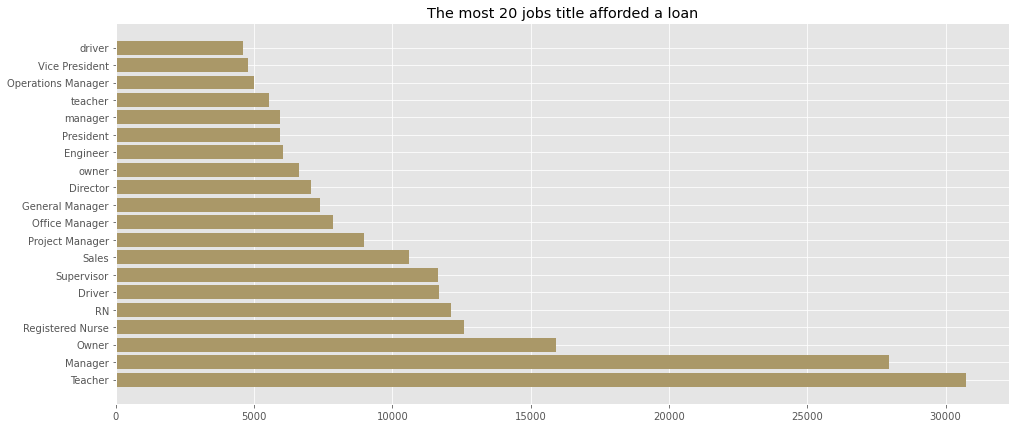

In [59]:
plt.figure(figsize=(16,7))
plt.barh(loan['emp_title'].value_counts()[:20].index, loan['emp_title'].value_counts()[:20], color='#AA9868')
plt.title("The most 20 jobs title afforded a loan")


In [60]:
loan['emp_length'].unique()

array(['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '6 years', '2 years', '7 years', nan],
      dtype=object)

<AxesSubplot:xlabel='emp_length', ylabel='count'>

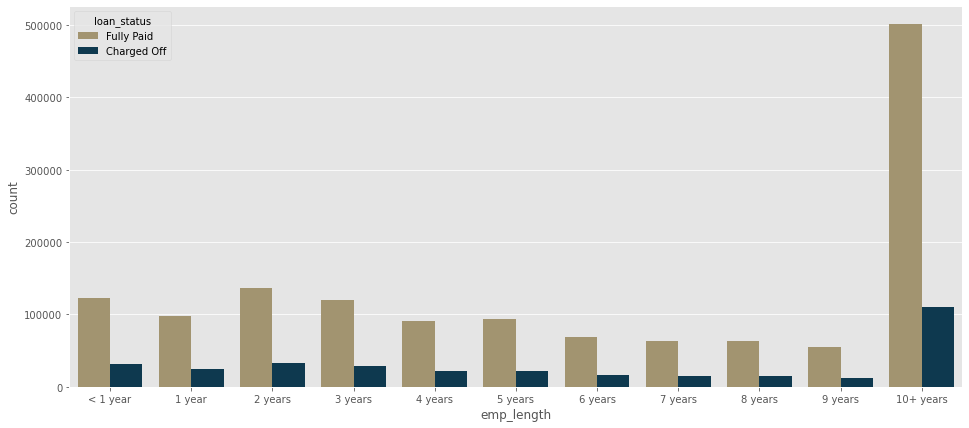

In [61]:
plt.figure(figsize=(16, 7))
order = ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', 
          '6 years', '7 years', '8 years', '9 years', '10+ years',]
sns.countplot(x='emp_length', data=loan, hue='loan_status', order=order, palette=gwu)

Text(0.5, 1.0, 'Charged Off Ratio by Employee Length')

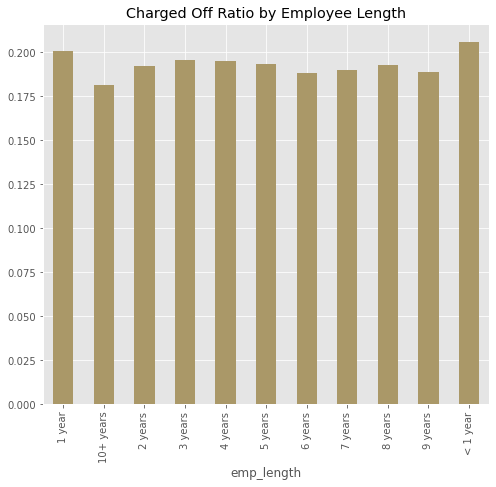

In [62]:
plt.figure(figsize=(8,7))
cfratio(loan,'emp_length').plot(kind='bar', color='#AA9868')
plt.title('Charged Off Ratio by Employee Length')

There is no significant change in years for loan status. So we will drop it later.

In [63]:
dropl.append('emp_length')

**purpose vs title**

purpose: A category provided by the borrower for the loan request.

title: The loan title provided by the borrower.

In [64]:
loan['purpose'].value_counts()

debt_consolidation    1063459
credit_card            412844
home_improvement       123861
other                  113589
major_purchase          41750
medical                 22578
small_business          20515
car                     20215
vacation                13333
moving                  13203
house                   11099
wedding                  2298
renewable_energy         1260
educational               327
Name: purpose, dtype: int64

In [65]:
loan['title'].value_counts()

Debt consolidation                                                941169
Credit card refinancing                                           366391
Home improvement                                                  111152
Other                                                             102322
Major purchase                                                     36294
                                                                   ...  
eCommerce Investment Consolidation                                     1
Educational Debt - Credit Card                                         1
Home Payoff                                                            1
Reduce Payment                                                         1
Excellent Credit History - Employed continuously for 16+ years         1
Name: title, Length: 61685, dtype: int64

View the top 15 titles and their frequency

In [66]:
loan['title'].value_counts().head(15)

Debt consolidation         941169
Credit card refinancing    366391
Home improvement           111152
Other                      102322
Major purchase              36294
Medical expenses            20548
Business                    16806
Car financing               16802
Debt Consolidation          15695
Vacation                    12273
Moving and relocation       11651
Home buying                  9725
Consolidation                5355
debt consolidation           4813
Debt Consolidation Loan      3777
Name: title, dtype: int64

There are more than 60000 different titles. Based on the top 15 titles, it seems the purpose variable already contains information of title variable. So we will drop the title variable later.

In [67]:
dropl.append('title')

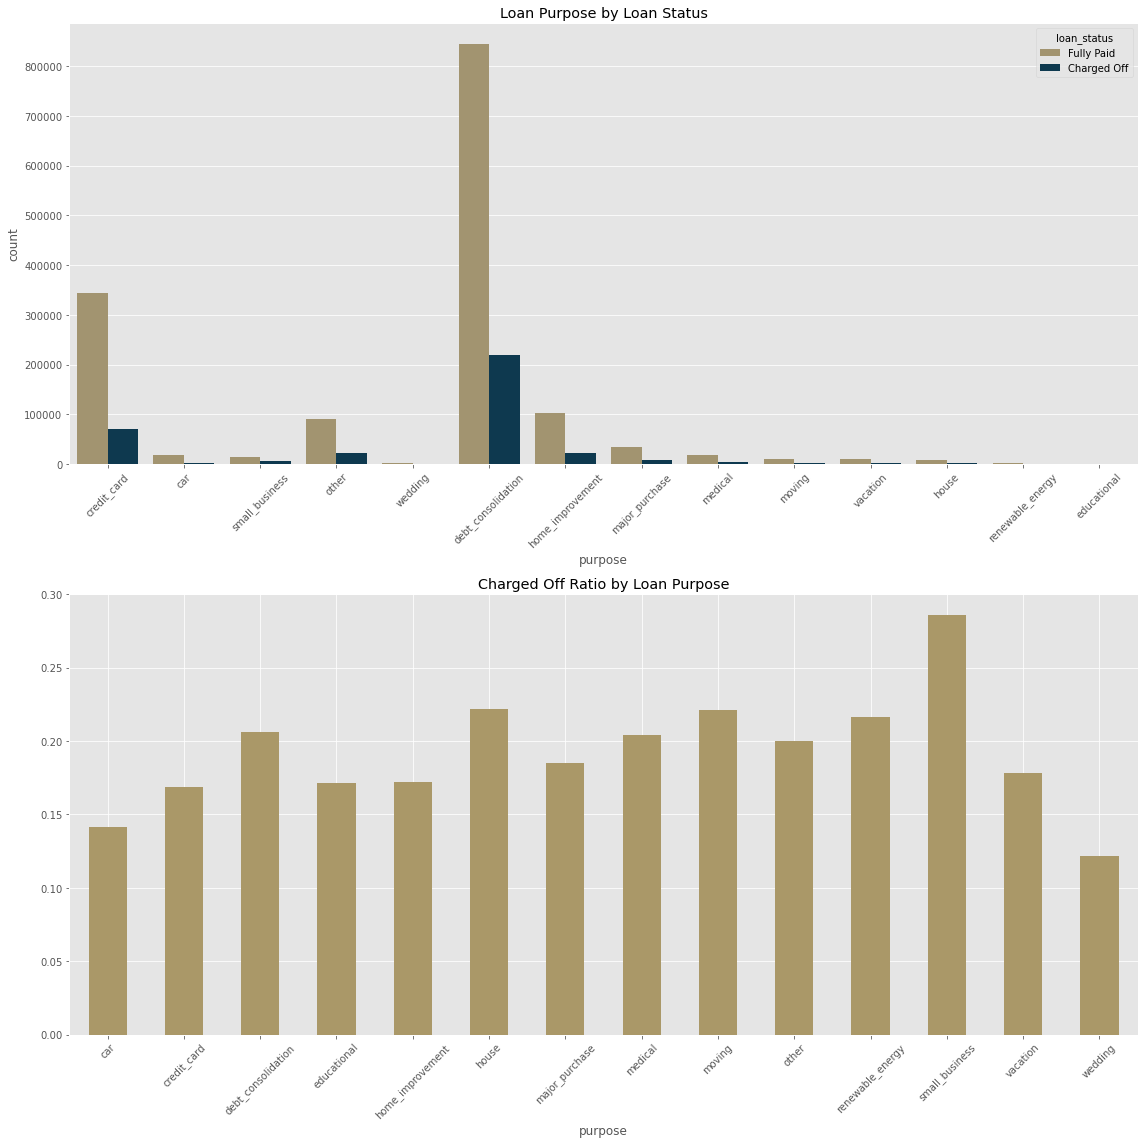

In [68]:
plt.figure(figsize=(16,16))
plt.subplot(2,1,1)
sns.countplot(x='purpose', data=loan, hue='loan_status', palette=gwu)
plt.xticks(rotation=45)
plt.title('Loan Purpose by Loan Status')
plt.subplot(2,1,2)
cfratio(loan,'purpose').plot(kind='bar',color='#AA9868')
plt.xticks(rotation=45)
plt.title('Charged Off Ratio by Loan Purpose')
plt.tight_layout()

Loans for debt consolidation have the highest counts, also the highest counts of fully paid and charged off. But the highest charged off percent belongs to loans for small business. And loans for wedding have the smallest charged off percent.

**mort_acc**

mort_acc:  Number of mortgage accounts.

In [69]:
loan['mort_acc'].value_counts()

0.0     747953
1.0     319708
2.0     266554
3.0     191975
4.0     127349
5.0      75161
6.0      41412
7.0      21061
8.0      10418
9.0       5277
10.0      2711
11.0      1428
12.0       747
13.0       424
14.0       285
15.0       164
16.0       108
17.0        76
18.0        58
19.0        34
20.0        31
24.0        17
22.0        16
23.0        16
21.0        15
25.0        10
27.0         8
26.0         6
28.0         5
29.0         4
31.0         3
34.0         3
32.0         2
30.0         2
37.0         2
61.0         1
45.0         1
51.0         1
33.0         1
36.0         1
47.0         1
35.0         1
Name: mort_acc, dtype: int64

Text(0.5, 1.0, 'Charged Off Ratio by Mortgage Accounts')

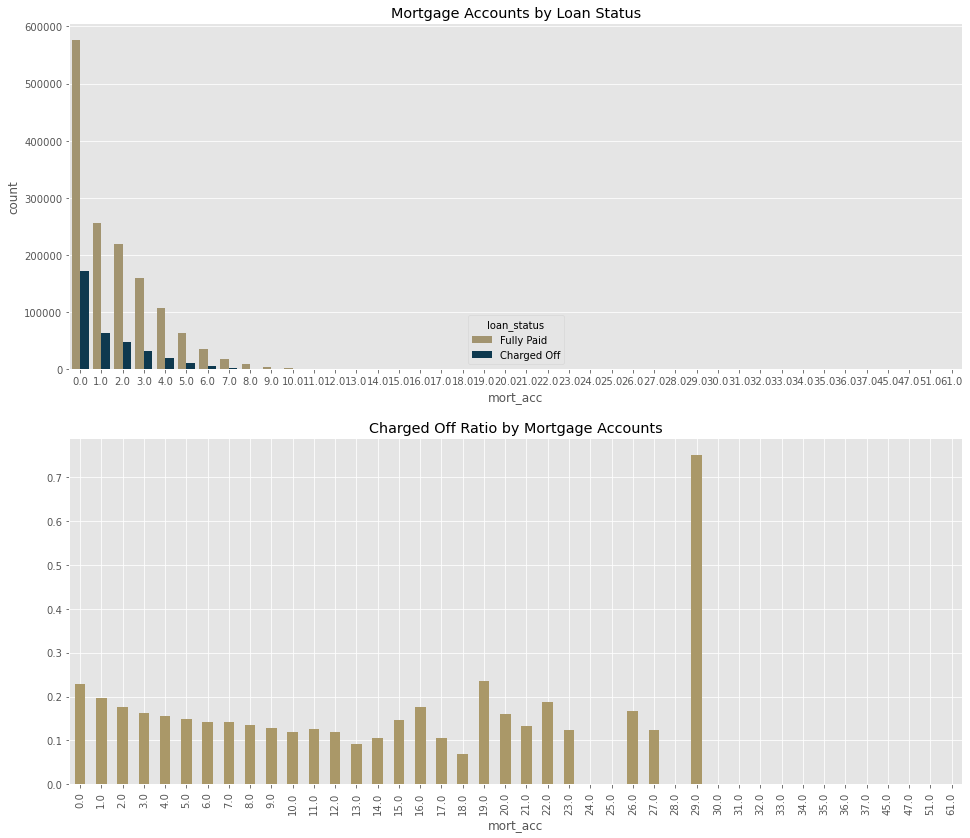

In [70]:
plt.figure(figsize=(16,14))
plt.subplot(2,1,1)
sns.countplot(data=loan, x='mort_acc', hue='loan_status', palette=gwu)
plt.title('Mortgage Accounts by Loan Status')
plt.subplot(2,1,2)
cfratio(loan,'mort_acc').plot(kind='bar', color='#AA9868')
plt.title('Charged Off Ratio by Mortgage Accounts')

When mortgage accounts number less than 10, the number of mortgage account is proportional to the charged off ratio.  When the number more than 11, there is no obvious pattern.

**term**

term: The number of payments on the loan. Values are in months and can be either 36 or 60.

In [71]:
loan['term'].value_counts()

 36 months    1393299
 60 months     467032
Name: term, dtype: int64

Convert term variable to integers.

In [72]:
loan['term'] = loan['term'].apply(lambda v:np.int8(v.split()[0]))


In [73]:
loan['term'].value_counts()

36    1393299
60     467032
Name: term, dtype: int64

Text(0.5, 1.0, 'Charged Off Ratio by Terms')

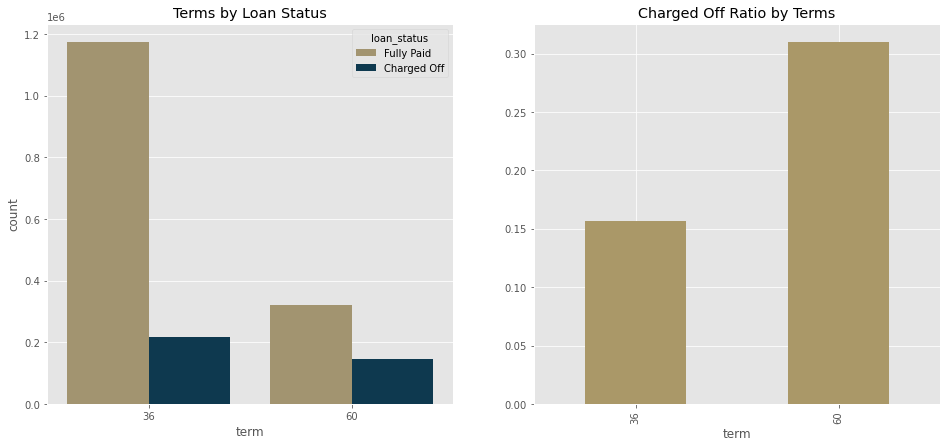

In [74]:
plt.figure(figsize=(16,7))
plt.subplot(1,2,1)
sns.countplot(data=loan, x='term', hue='loan_status', palette=gwu)
plt.title('Terms by Loan Status')
plt.subplot(1,2,2)
cfratio(loan,'term').plot(kind='bar', color='#AA9868')
plt.title('Charged Off Ratio by Terms')

The loan with 36-month payment times has the higher counts of either fully Paid or charged Off, but the lower charged off percent. The loan with 60-month payment times has the higher charged off percent.

**int_rate**

int_rate: Interest Rate on the loan.

In [75]:
loan['int_rate'].unique()

array([' 10.65%', ' 15.27%', ' 15.96%', ' 13.49%', ' 12.69%', '  7.90%',
       ' 18.64%', ' 21.28%', ' 14.65%', '  9.91%', ' 16.29%', '  6.03%',
       ' 11.71%', ' 12.42%', ' 14.27%', ' 16.77%', '  7.51%', '  8.90%',
       ' 18.25%', '  6.62%', ' 19.91%', ' 17.27%', ' 17.58%', ' 21.67%',
       ' 19.42%', ' 22.06%', ' 20.89%', ' 20.30%', ' 23.91%', ' 19.03%',
       ' 23.52%', ' 23.13%', ' 22.74%', ' 22.35%', ' 24.11%', '  6.00%',
       ' 22.11%', '  7.49%', ' 11.99%', '  5.99%', ' 10.99%', '  9.99%',
       ' 18.79%', ' 11.49%', '  8.49%', ' 15.99%', ' 16.49%', '  6.99%',
       ' 12.99%', ' 15.23%', ' 14.79%', '  5.42%', ' 10.59%', ' 17.49%',
       ' 15.62%', ' 21.36%', ' 19.29%', ' 13.99%', ' 18.39%', ' 16.89%',
       ' 17.99%', ' 20.62%', ' 20.99%', ' 22.85%', ' 19.69%', ' 20.25%',
       ' 23.22%', ' 21.74%', ' 22.48%', ' 23.59%', ' 12.62%', ' 18.07%',
       ' 11.63%', '  7.91%', '  7.42%', ' 11.14%', ' 20.20%', ' 12.12%',
       ' 19.39%', ' 16.11%', ' 17.54%', ' 22.64%', 

Remove percent sign from int_rate variable and convert it into float

In [76]:
loan['int_rate'] = loan['int_rate'].map(lambda x: x.replace('%','')).astype(np.float64)

Text(0.5, 1.0, 'Interest Rate by Loan Status')

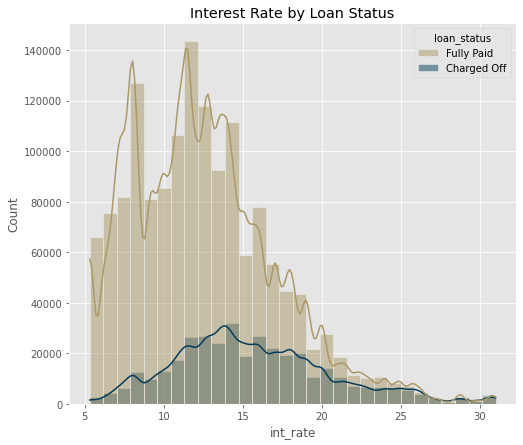

In [77]:
plt.figure(figsize=(8,7))
sns.histplot(data=loan, x='int_rate', hue='loan_status', bins=30, kde=True, palette=gwu)
plt.title('Interest Rate by Loan Status')

Group the int_rate column.

Text(0.5, 1.0, 'Charged Off Ratio by Interest Rate')

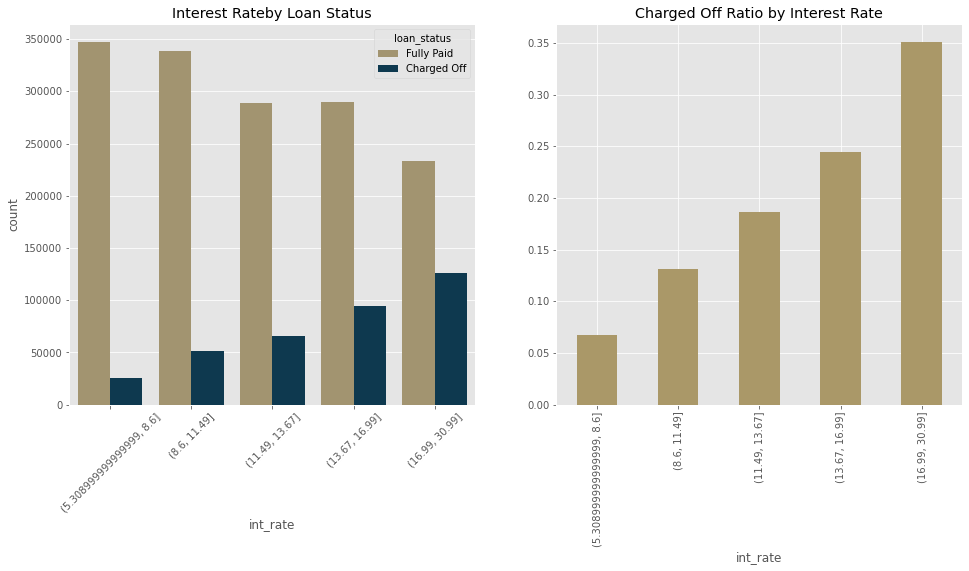

In [78]:
plt.figure(figsize=(16,7))
plt.subplot(1,2,1)
sns.countplot(data=loan, x=group('int_rate',5), hue='loan_status', palette=gwu)
plt.xticks(rotation=45)
plt.title('Interest Rateby Loan Status')
plt.subplot(1,2,2)
cfratio(loan,group('int_rate',5)).plot(kind='bar', color='#AA9868')
plt.title('Charged Off Ratio by Interest Rate')

It seems that loans with high interest rate are more likely to be charged off.

**home_ownership**

home_ownership: The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER.

In [79]:
loan['home_ownership'].value_counts()

MORTGAGE    918028
RENT        735358
OWN         205578
ANY           1174
OTHER          144
NONE            49
Name: home_ownership, dtype: int64

Replace 'ANY' and 'NONE' with 'OTHER'

In [80]:
loan['home_ownership'].replace(['ANY','NONE'],'OTHER', inplace=True)

Text(0.5, 1.0, 'Charged Off Ratio by Home Ownership')

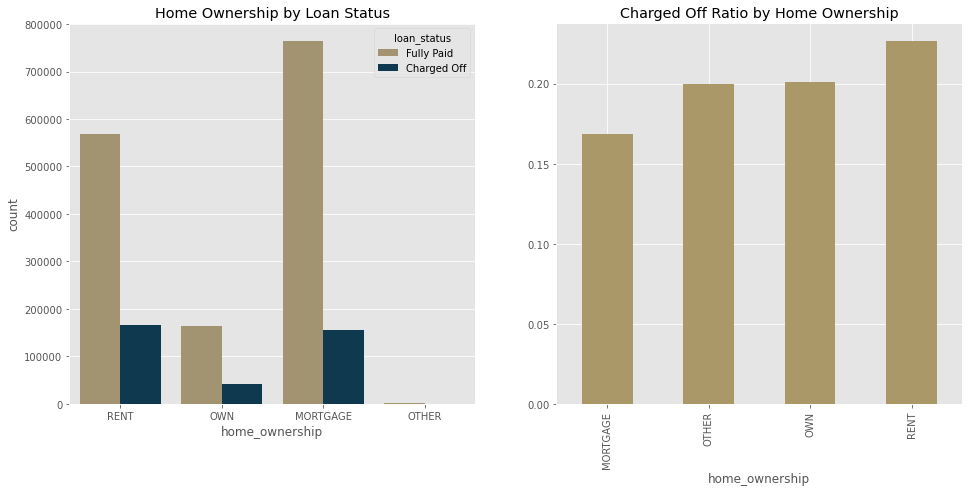

In [81]:
plt.figure(figsize=(16,7))
plt.subplot(1,2,1)
sns.countplot(data=loan, x='home_ownership', hue='loan_status', palette=gwu)
plt.title('Home Ownership by Loan Status')
plt.subplot(1,2,2)
cfratio(loan,'home_ownership').plot(kind='bar', color='#AA9868')
plt.title('Charged Off Ratio by Home Ownership')

MORTGAGE has the highest value of fully paid and the lowest charged off ratio. RENT has the highest charged off ratio.

**annual_inc**

annual_inc: The self-reported annual income provided by the borrower during registration.


In [82]:
loan['annual_inc'].describe()

count    1.860331e+06
mean     7.736956e+04
std      1.178218e+05
min      0.000000e+00
25%      4.600000e+04
50%      6.500000e+04
75%      9.200000e+04
max      1.100000e+08
Name: annual_inc, dtype: float64

The annual income variable has a large range which ranges from 0 to 110 million. So we will take a log transform of the annual income to analysis this varaible.

In [83]:
loan['log_annual_inc'] = np.log(loan[loan['annual_inc']>0]['annual_inc'])


Text(0.5, 1.0, 'Annual Income Distribution by Loan Status')

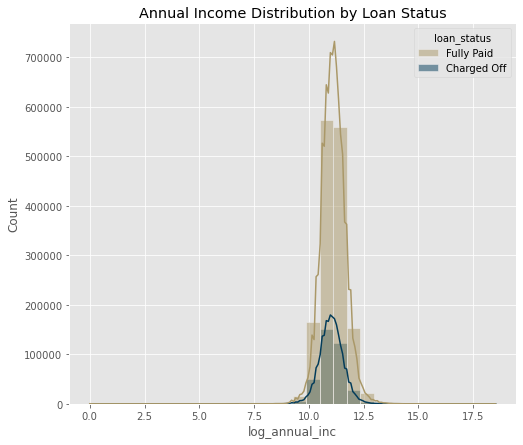

In [84]:
plt.figure(figsize=(8,7))
sns.histplot(data=loan, x='log_annual_inc', hue='loan_status', bins=30, kde=True, palette=gwu)
plt.title('Annual Income Distribution by Loan Status')

Try to group annual income to see the charged off percent for each annual income group。

Text(0.5, 1.0, 'Charged Off Ratio by Annual Income')

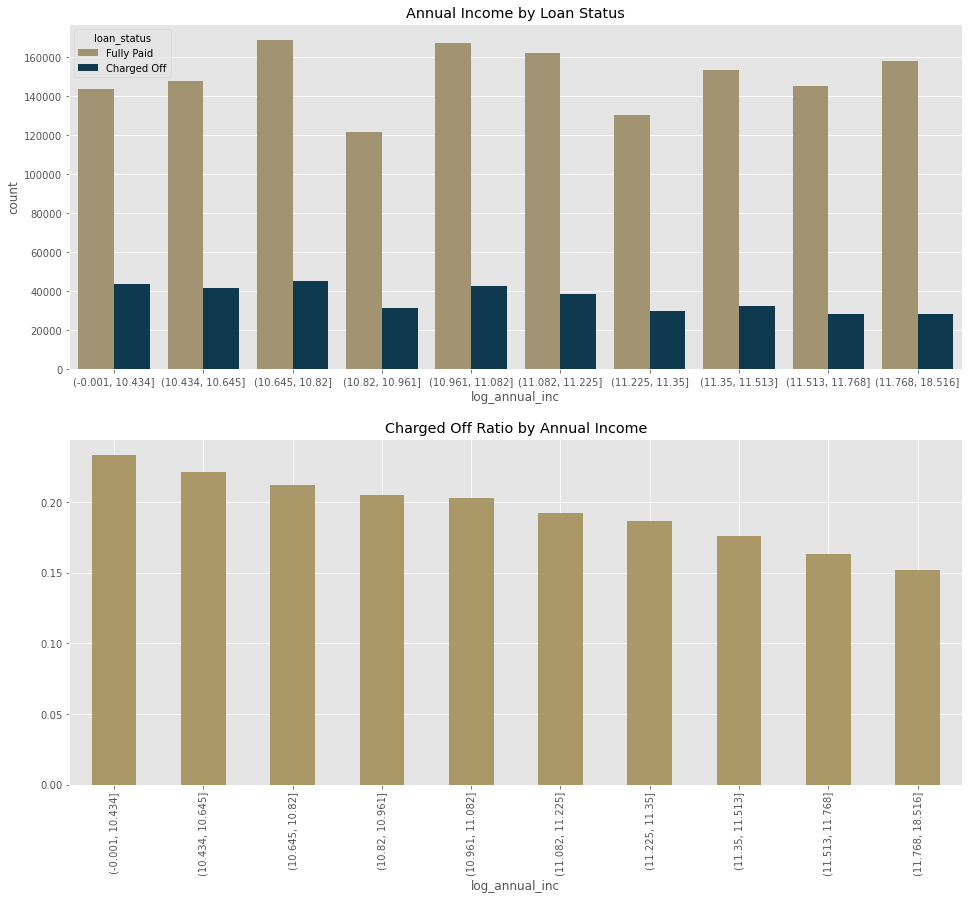

In [85]:
plt.figure(figsize=(16,14))
plt.subplot(2,1,1)
sns.countplot(data=loan, x=group('log_annual_inc',10), hue='loan_status', palette=gwu)
plt.title('Annual Income by Loan Status')
plt.subplot(2,1,2)
cfratio(loan,group('log_annual_inc',10)).plot(kind='bar', color='#AA9868')
plt.title('Charged Off Ratio by Annual Income')

The lower the income, the higher the charged off percent.

In [86]:
dropl.append('log_annual_inc')

**verification_status**

verification_status: Indicates if income was verified by LC, not verified, or if the income source was verified.

In [87]:
loan['verification_status'].value_counts()

Source Verified    734068
Not Verified       588361
Verified           537902
Name: verification_status, dtype: int64

Text(0.5, 1.0, 'Charged Off Ratio by Verification Status')

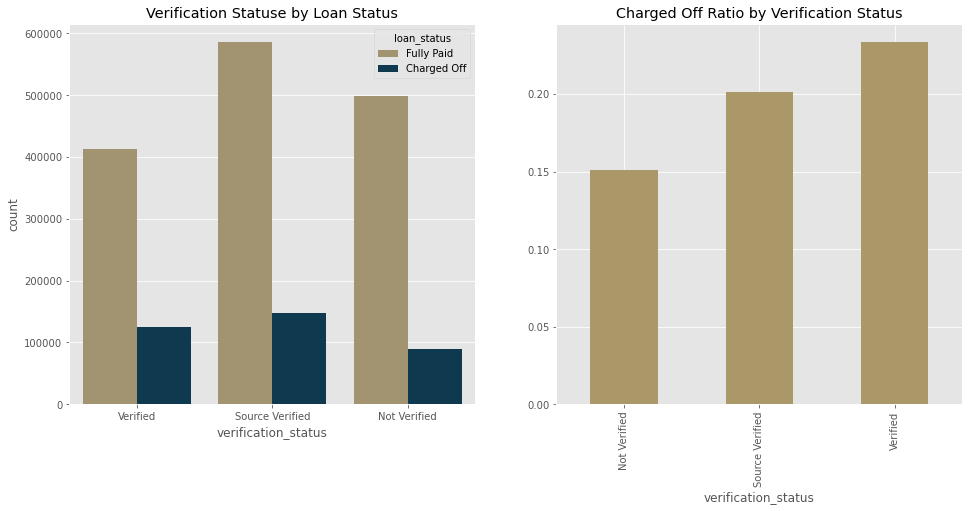

In [88]:
plt.figure(figsize=(16,7))
plt.subplot(1,2,1)
sns.countplot(data=loan, x='verification_status', hue='loan_status', palette=gwu)
plt.title('Verification Statuse by Loan Status')
plt.subplot(1,2,2)
cfratio(loan,'verification_status').plot(kind='bar', color='#AA9868')
plt.title('Charged Off Ratio by Verification Status')

People whose annual income been verified have the highest default rates.

**dti**

dti: A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income. 

Text(0.5, 1.0, 'dti by Loan Status')

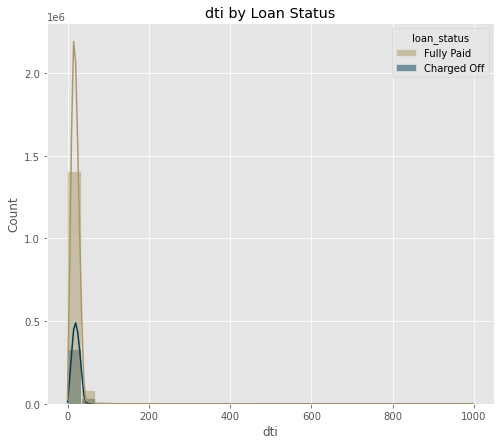

In [89]:
plt.figure(figsize=(8,7))
sns.histplot(data=loan, x='dti', hue='loan_status', bins=30, kde=True, palette=gwu)
plt.title('dti by Loan Status')

In [90]:
print('The statistic information of dti:\n',loan['dti'].describe())
print('The value counts of dti:\n',loan['dti'].value_counts())

The statistic information of dti:
 count    1.859223e+06
mean     1.856774e+01
std      1.309153e+01
min     -1.000000e+00
25%      1.182000e+01
50%      1.771000e+01
75%      2.429000e+01
max      9.990000e+02
Name: dti, dtype: float64
The value counts of dti:
 0.00      1355
19.20     1343
18.00     1322
14.40     1318
16.80     1311
          ... 
137.50       1
107.41       1
54.09        1
51.07        1
62.56        1
Name: dti, Length: 9346, dtype: int64


Text(0.5, 1.0, 'Charged Off Ratio by dti')

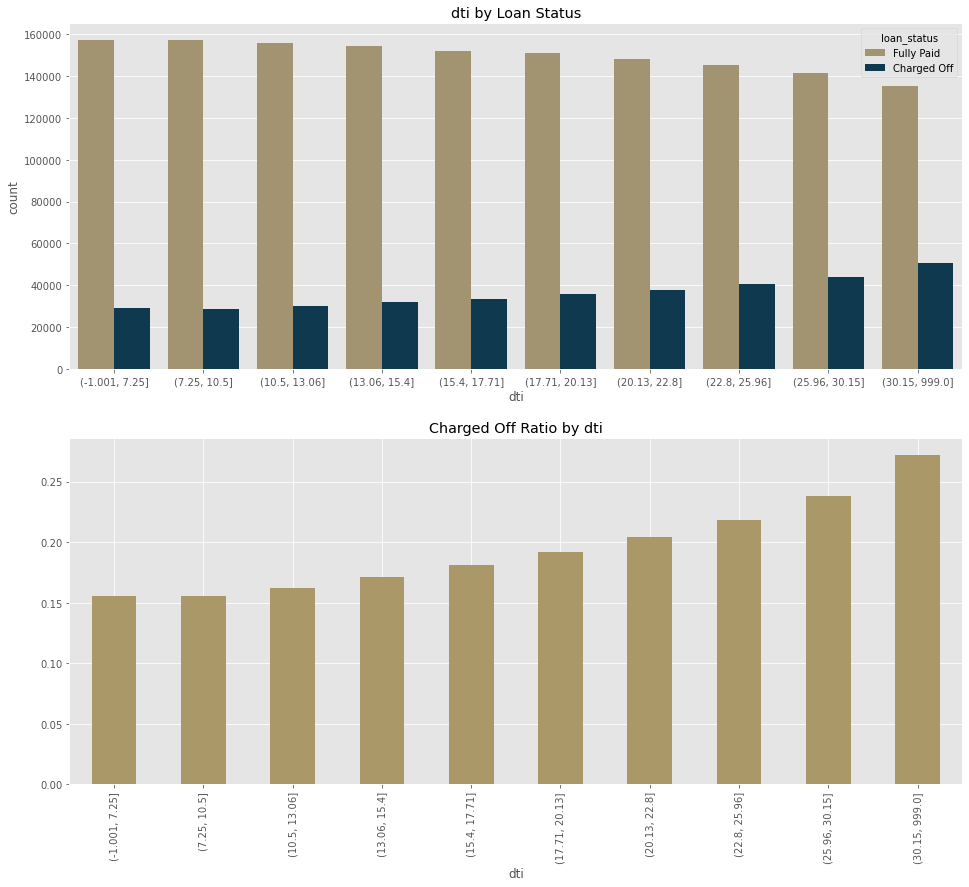

In [91]:
plt.figure(figsize=(16,14))
plt.subplot(2,1,1)
sns.countplot(data=loan, x=group('dti',10), hue='loan_status', palette=gwu)
plt.title('dti by Loan Status')
plt.subplot(2,1,2)
cfratio(loan,group('dti',10)).plot(kind='bar', color='#AA9868')
plt.title('Charged Off Ratio by dti')

The value of dti is mainly in the range of 0 to 30. We can clearly see that as the dti grows, so does the charged off percent.

**earliest_cr_line**

earliest_cr_line: The month the borrower's earliest reported credit line was opened.

In [92]:
loan['earliest_cr_line'].value_counts()

Sep-2003    12568
Sep-2004    12561
Aug-2001    12170
Aug-2002    12113
Aug-2003    12027
            ...  
Sep-1957        1
Dec-1946        1
Mar-1958        1
Jun-1956        1
Feb-1945        1
Name: earliest_cr_line, Length: 763, dtype: int64

The format of 'earliest_cr_line' is like 'issue_d', we will use the same method to grab the year of this column.

In [93]:
loan['earliest_cr_line'] = pd.DatetimeIndex(loan['earliest_cr_line']).year

For easy understanding, we then convert the year into 'age' of the earliest reported credit line.

In [94]:
loan['earliest_cr_line_y'] = 2021-loan['earliest_cr_line']

In [95]:
dropl.append('earliest_cr_line')

Text(0.5, 1.0, 'dti by Years of Earlist Credit Line')

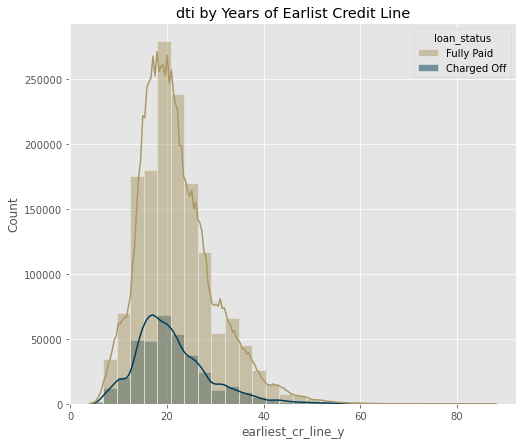

In [96]:
plt.figure(figsize=(8,7))
sns.histplot(data=loan, x='earliest_cr_line_y', hue='loan_status', bins=30, kde=True, palette=gwu)
plt.title('dti by Years of Earlist Credit Line')

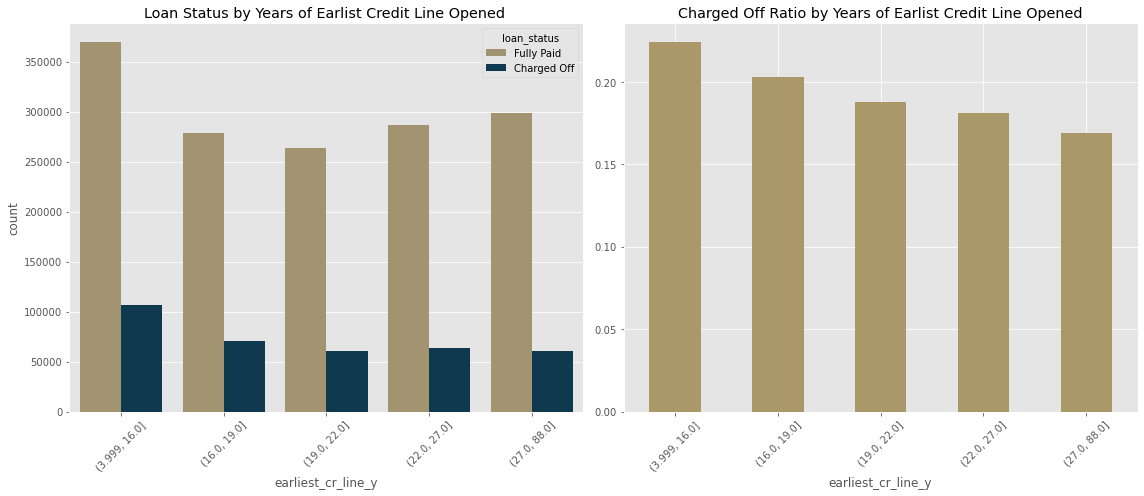

In [97]:
plt.figure(figsize=(16,7))
plt.subplot(1,2,1)
sns.countplot(x=group('earliest_cr_line_y',5), data=loan, hue='loan_status', palette=gwu)
plt.xticks(rotation=45)
plt.title('Loan Status by Years of Earlist Credit Line Opened ')
plt.subplot(1,2,2)
cfratio(loan,group('earliest_cr_line_y',5)).plot(kind='bar',color='#AA9868')
plt.xticks(rotation=45)
plt.title('Charged Off Ratio by Years of Earlist Credit Line Opened')
plt.tight_layout()

Borrowers with high charged off ratio usually has short lines of credits.

**revol_bal**

revol_bal: Total credit revolving balance.

Text(0.5, 1.0, 'Loan Status by Credits Revolving Balance')

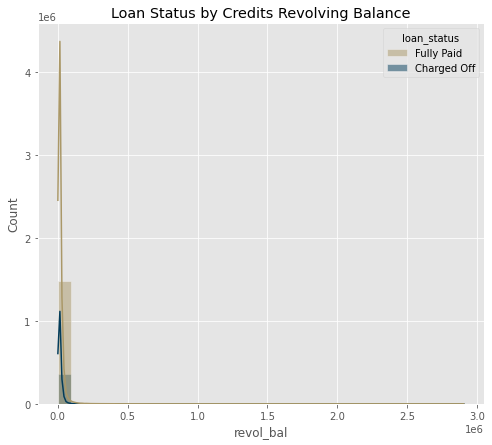

In [98]:
plt.figure(figsize=(8,7))
sns.histplot(data=loan, x='revol_bal', hue='loan_status', bins=30, kde=True, palette=gwu)
plt.title('Loan Status by Credits Revolving Balance')

In [99]:
loan['log_revol_bal'] = np.log(loan[loan['revol_bal']>0]['revol_bal'])

Text(0.5, 1.0, 'Loan Status by Credits Revolving Balance')

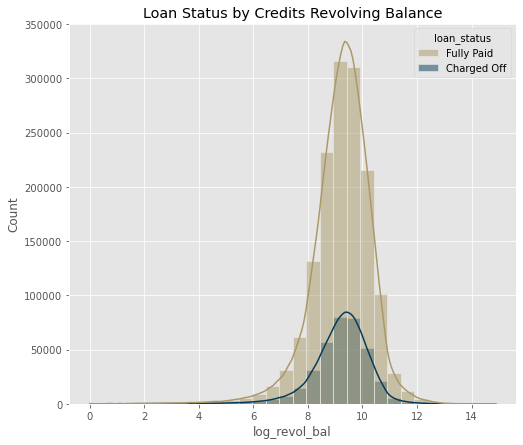

In [100]:
plt.figure(figsize=(8,7))
sns.histplot(data=loan, x='log_revol_bal', hue='loan_status', bins=30, kde=True, palette=gwu)
plt.title('Loan Status by Credits Revolving Balance')

Text(0.5, 1.0, 'Charged Off Ratio by Credits Revolving Balance')

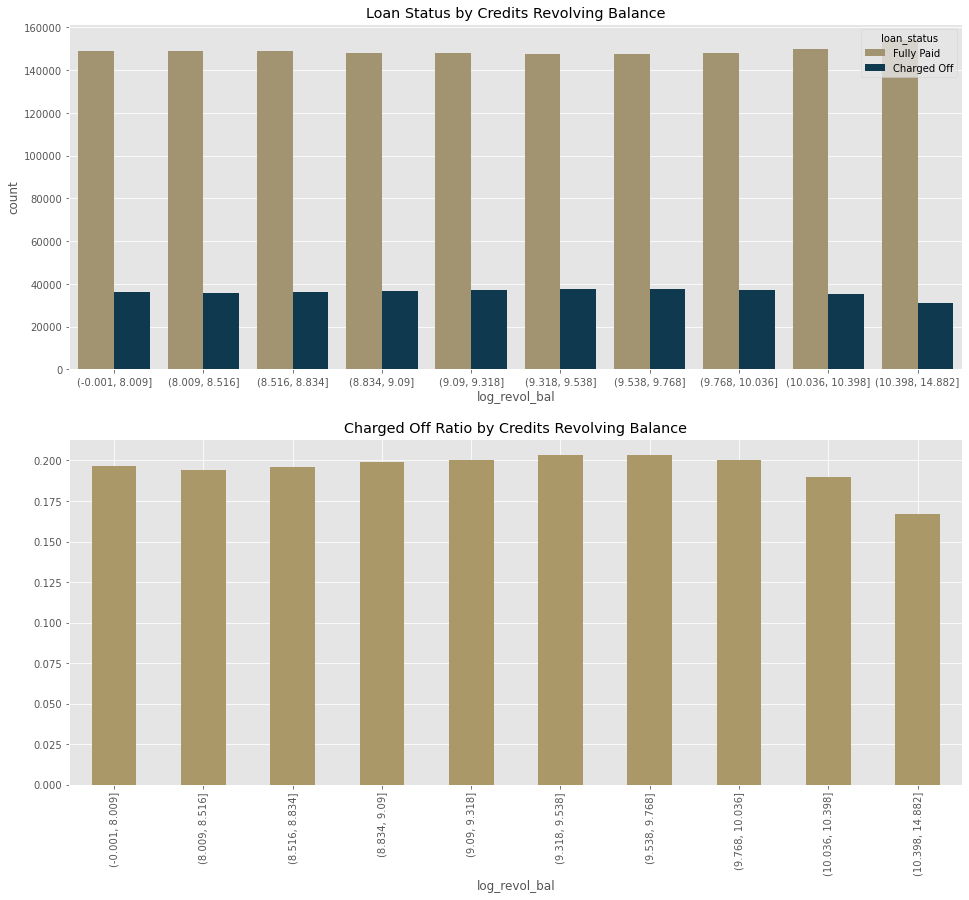

In [101]:
plt.figure(figsize=(16,14))
plt.subplot(2,1,1)
sns.countplot(data=loan, x=group('log_revol_bal',10), hue='loan_status', palette=gwu)
plt.title('Loan Status by Credits Revolving Balance')
plt.subplot(2,1,2)
cfratio(loan,group('log_revol_bal',10)).plot(kind='bar', color='#AA9868')
plt.title('Charged Off Ratio by Credits Revolving Balance')

As the revolving balance increase, the charged off ratio slightly decrease.

In [102]:
dropl.append('log_revol_bal')

**revol_util**

revol_util: Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.

We first to remove % sign from 'revol_util' and convert ti into float.

In [103]:
loan['revol_util'] = loan['revol_util'].map(lambda x: str(x).replace('%','')).astype(np.float64)

Text(0.5, 1.0, 'Loan Status by Revolving Line Utilization Rate')

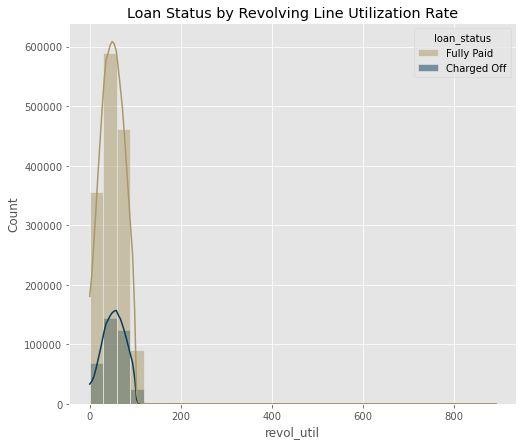

In [104]:
plt.figure(figsize=(8,7))
sns.histplot(data=loan, x='revol_util', hue='loan_status', bins=30, kde=True, palette=gwu)
plt.title('Loan Status by Revolving Line Utilization Rate')

Text(0.5, 1.0, 'Charged Off Ratio by Revolving Line Utilization Rate')

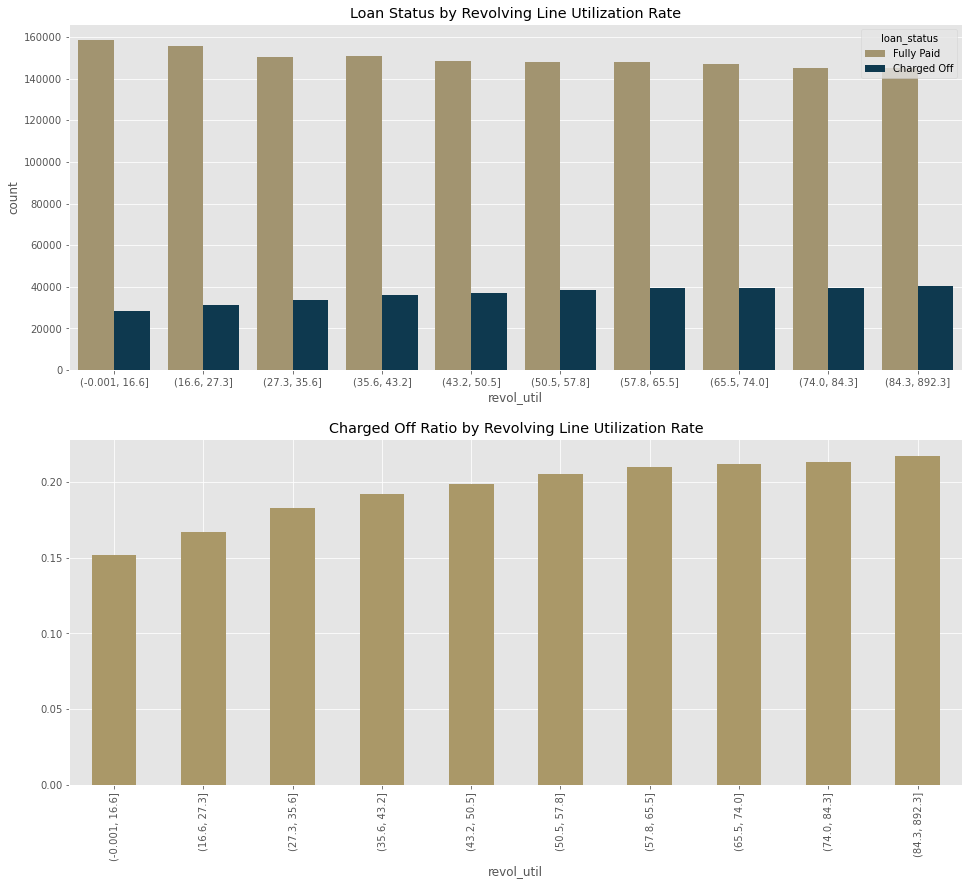

In [105]:
plt.figure(figsize=(16,14))
plt.subplot(2,1,1)
sns.countplot(data=loan, x=group('revol_util',10), hue='loan_status', palette=gwu)
plt.title('Loan Status by Revolving Line Utilization Rate')
plt.subplot(2,1,2)
cfratio(loan,group('revol_util',10)).plot(kind='bar', color='#AA9868')
plt.title('Charged Off Ratio by Revolving Line Utilization Rate')

As the revolving line utilization rate grows, the charged off percent increase.

**initial_list_status**

initial_list_status: The initial listing status of the loan. Possible values are – W, F. W means Whole, F means Fraction.

In [106]:
loan['initial_list_status'].value_counts()

w    1194912
f     665419
Name: initial_list_status, dtype: int64

Text(0.5, 1.0, 'Charged Off Ratio by Initial List Status')

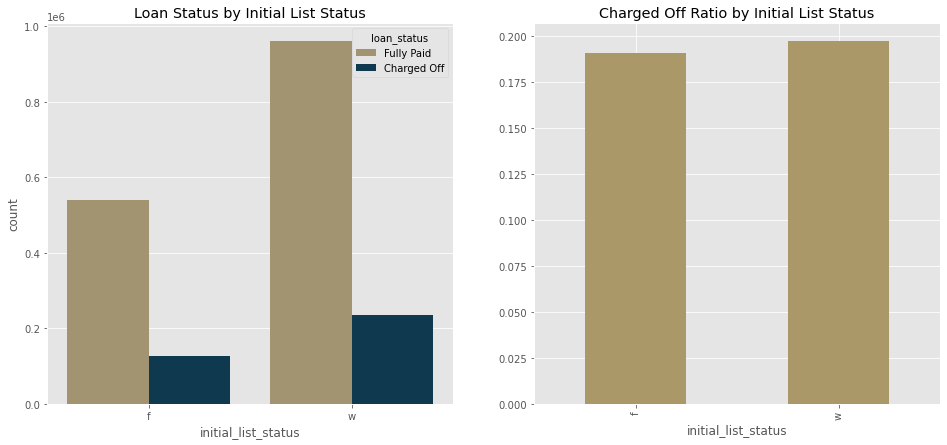

In [107]:
plt.figure(figsize=(16,7))
plt.subplot(1,2,1)
sns.countplot(data=loan, x='initial_list_status', hue='loan_status', palette=gwu)
plt.title('Loan Status by Initial List Status')
plt.subplot(1,2,2)
cfratio(loan,'initial_list_status').plot(kind='bar', color='#AA9868')
plt.title('Charged Off Ratio by Initial List Status')

Whole loan has higher number of loans also higher charged off ratio. 

**application_type**

application_type: Indicates whether the loan is an individual application or a joint application with two co-borrowers.

In [108]:
loan['application_type'].value_counts()

Individual    1790838
Joint App       69493
Name: application_type, dtype: int64

Text(0.5, 1.0, 'Charged Off Ratio by Application Type')

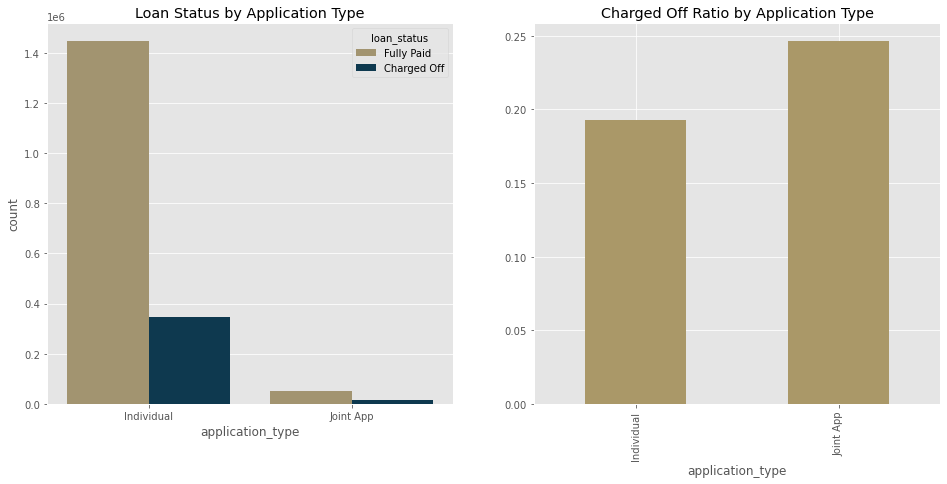

In [109]:
plt.figure(figsize=(16,7))
plt.subplot(1,2,1)
sns.countplot(data=loan, x='application_type', hue='loan_status', palette=gwu)
plt.title('Loan Status by Application Type')
plt.subplot(1,2,2)
cfratio(loan,'application_type').plot(kind='bar', color='#AA9868')
plt.title('Charged Off Ratio by Application Type')

The number of individual application is pretty higher than joint application. But the charged off percent of joit application is more higher. It seems Joint loans are slightly more likely to be charged off.

**addr_state**

In [110]:
by_state = loan.groupby(['addr_state','loan_status'])['loan_status'].agg(counts='count').reset_index()
by_state_pivot = by_state.pivot_table(values='counts',index='addr_state',columns='loan_status').reset_index()
by_state_pivot.head()

loan_status addr_state  Charged Off  Fully Paid
0                   AK          823        3519
1                   AL         5177       17621
2                   AR         3323       10759
3                   AZ         8648       36860
4                   CA        51454      213009

In [111]:
by_state_pivot['charged_off_percentage'] = by_state_pivot['Charged Off']/(by_state_pivot['Charged Off']+by_state_pivot['Fully Paid'])

In [112]:
data = dict(type = 'choropleth',
            locations = by_state_pivot['addr_state'],
            locationmode = 'USA-states',
            z = by_state_pivot['charged_off_percentage'],# changable
            text = by_state_pivot['Charged Off'],
            marker = dict(line=dict(color='rgb(255,255,255)', width = 2)),
            colorscale = 'Oranges',
            colorbar = {'title':'Charged Off Percentage'},
            )
layout = dict(title = 'Charged Off Percentage of Each State',
              geo = dict(scope='usa'
                        #showlakes = True,
                        #lakecolor = 'rgb(0,191,255)'
                        )
              )
x = go.Figure(data = [data], layout = layout)
po.iplot(x)

Maine has the lowest charged off ratio which is about 12.82%, and Mississippi has the highest ratio which is about 24.89%

# **Data Preprocessing**

In this section, we need to :
- Remove variables in the drop list
- Remove or fill missing values
- Create dummy variables
- Train test split

## **Remove variables in the drop list**

We will use 'loan_status_flag' instead of 'loan_status' in the model, so we drop 'loan_status'.

In [113]:
dropl.extend(['loan_status','issue_y'])

In [114]:
print('We need to drop {} variables. They are:\n{}'.format(len(dropl),dropl))


We need to drop 14 variables. They are:
['issue_d', 'installment', 'total_acc', 'fico_range_high', 'fico_range_low', 'grade', 'emp_title', 'emp_length', 'title', 'log_annual_inc', 'earliest_cr_line', 'log_revol_bal', 'loan_status', 'issue_y']


In [115]:
dropl

['issue_d',
 'installment',
 'total_acc',
 'fico_range_high',
 'fico_range_low',
 'grade',
 'emp_title',
 'emp_length',
 'title',
 'log_annual_inc',
 'earliest_cr_line',
 'log_revol_bal',
 'loan_status',
 'issue_y']

In [116]:
loan.drop(dropl, axis=1, inplace=True)

In [117]:
loan.columns

Index(['loan_amnt', 'term', 'int_rate', 'sub_grade', 'home_ownership', 'annual_inc', 'verification_status', 'purpose', 'addr_state', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'initial_list_status', 'application_type', 'mort_acc', 'pub_rec_bankruptcies', 'loan_status_flag', 'fico', 'earliest_cr_line_y'], dtype='object')

## **Remove or fill missing values**

In [118]:
missing = round(loan.isnull().mean().sort_values(ascending=False), 4)
missing

mort_acc                0.0254
revol_util              0.0008
dti                     0.0006
pub_rec_bankruptcies    0.0004
loan_amnt               0.0000
pub_rec                 0.0000
fico                    0.0000
loan_status_flag        0.0000
application_type        0.0000
initial_list_status     0.0000
revol_bal               0.0000
open_acc                0.0000
term                    0.0000
addr_state              0.0000
purpose                 0.0000
verification_status     0.0000
annual_inc              0.0000
home_ownership          0.0000
sub_grade               0.0000
int_rate                0.0000
earliest_cr_line_y      0.0000
dtype: float64

<AxesSubplot:>

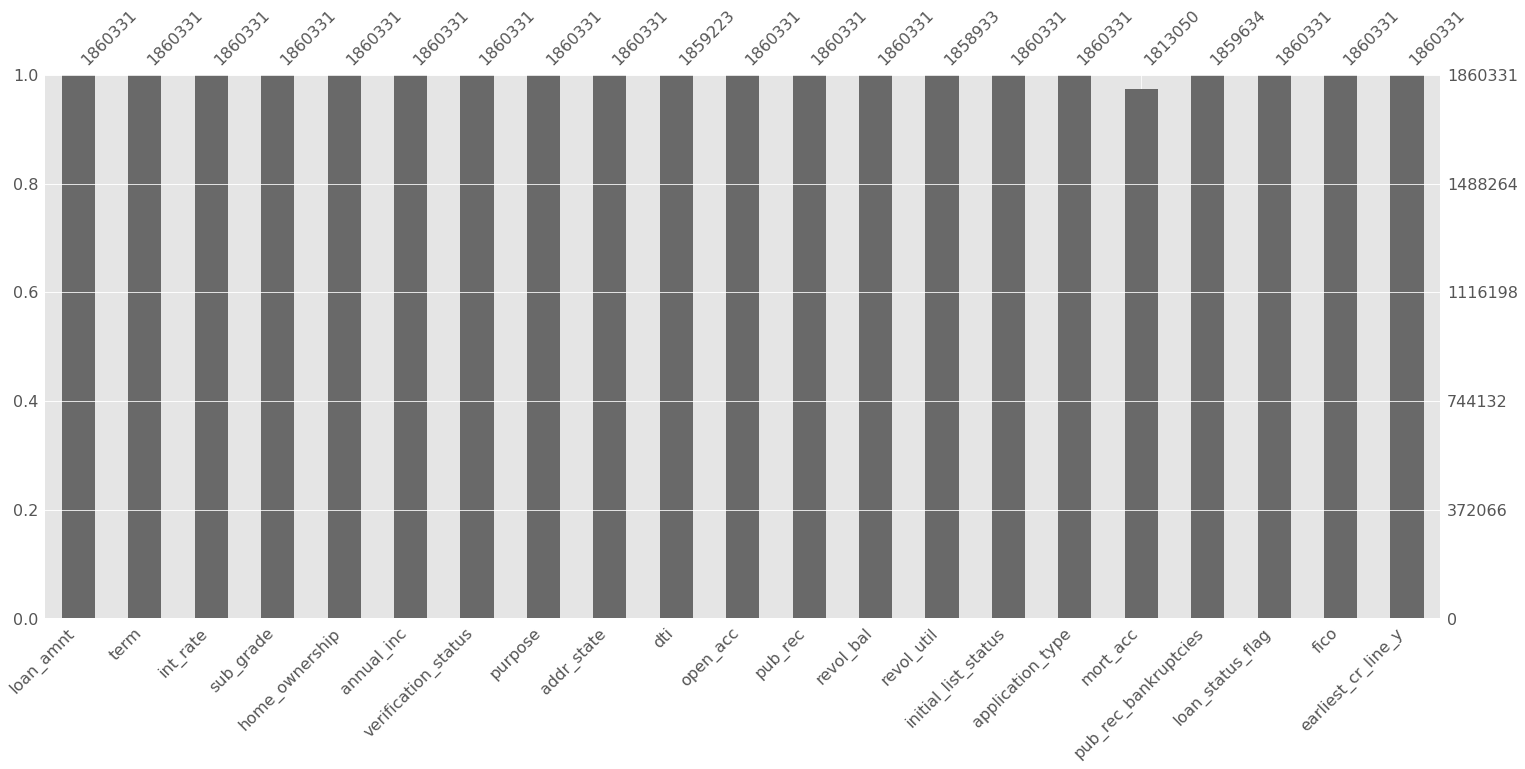

In [119]:
msno.bar(loan)

There are three features have missing data: 'mort_acc', 'revol_util' and 'dti', the missing percentage are 2.54%, 0.08% and 0.06%. Fot the features with low missing percentage like 'revol_util' and 'dti', we just simply drop the missing values. For 'mort_acc', we need to find a way to fill the missing data.

In [120]:
#find a variable correlated with 'mort_acc'
loan.corr()['mort_acc'].drop('mort_acc').sort_values()


int_rate               -0.088591
loan_status_flag       -0.073547
dti                    -0.016503
pub_rec                -0.010314
pub_rec_bankruptcies   -0.003043
revol_util              0.033569
fico                    0.095776
term                    0.105698
annual_inc              0.127762
open_acc                0.127802
revol_bal               0.211139
loan_amnt               0.221821
earliest_cr_line_y      0.291691
Name: mort_acc, dtype: float64

 'earliest_cr_line_y' has the highest correlation coefficient with  'mort_acc', as the years of earliest credit line opened increase, the number of mortgage accounts increase. We will group the data by 'total_acc' and calculate the average number of mortgage accounts for each group, then fill the 'mort_acc' variable.

In [121]:
mort_acc_avg = loan.groupby('earliest_cr_line_y').mean().mort_acc

In [122]:
mort_acc_avg.head()

earliest_cr_line_y
4    0.500000
5    0.157068
6    0.182973
7    0.194530
8    0.249885
Name: mort_acc, dtype: float64

In [123]:
def fill_mort_acc(earliest_cr_line_y, mort_acc):
    '''
    This function is to caculate the value filled in for each missing data.
    Input:
    total_acc
    '''
    if np.isnan(mort_acc):
        return mort_acc_avg[earliest_cr_line_y].round()
    else:
        return mort_acc

In [124]:
loan['mort_acc'] = loan.apply(lambda x: fill_mort_acc(x['earliest_cr_line_y'],x['mort_acc']), axis=1)

In [125]:
loan.dropna(inplace=True)

<AxesSubplot:>

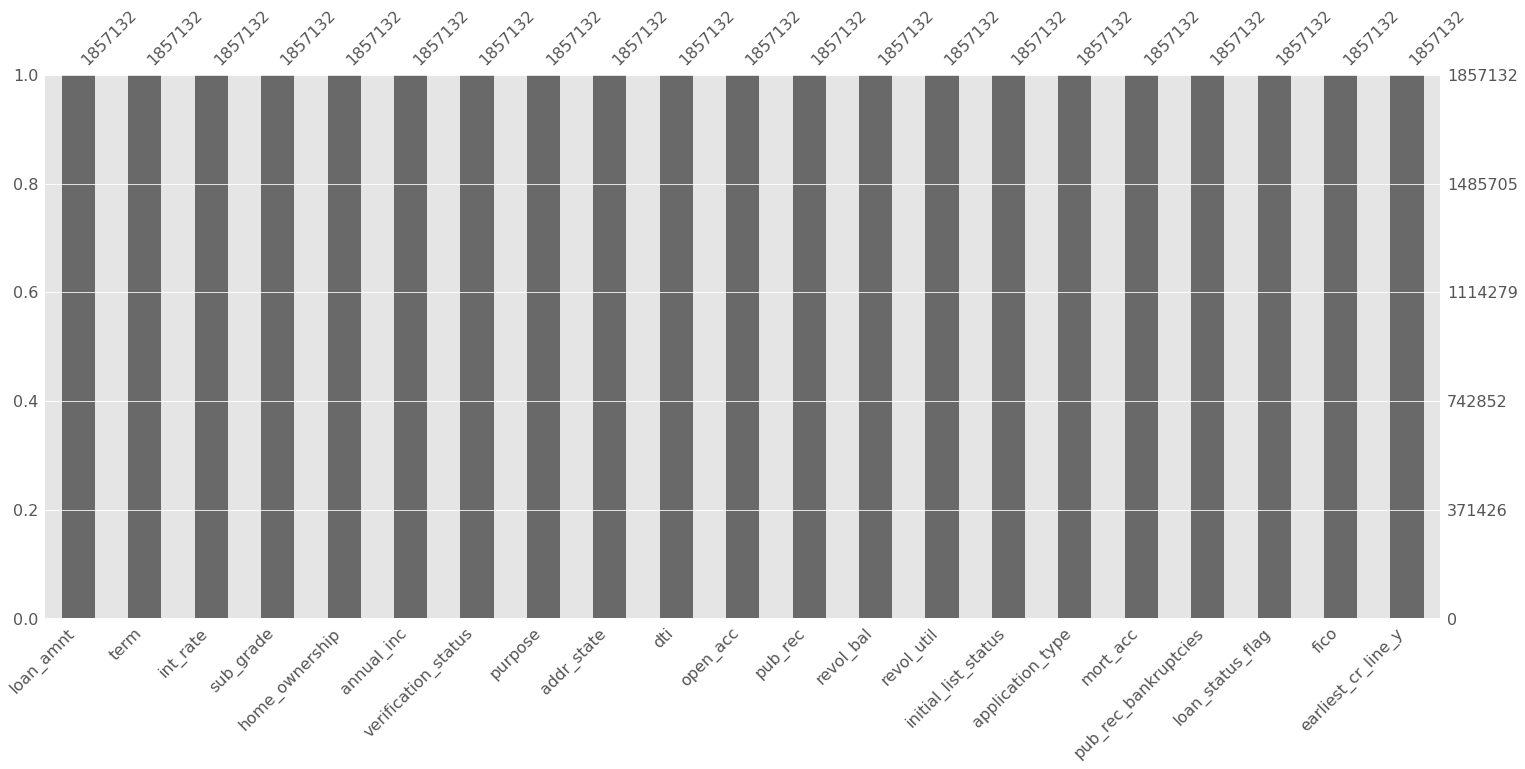

In [126]:
msno.bar(loan)

After dealing with missing value, we got 1857132 records.

In [128]:
#output the data
#loan.to_csv('loan.csv')